In [1]:
import subprocess
import os
import datetime
from dateutil.rrule import rrule, WEEKLY, MO
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import pygrib
import scipy 
from scipy import stats
import math
import matplotlib.pyplot as plt

# Data preparation

La direction du vent est généralement exprimée en degrés, avec des valeurs allant de 0 à 360 degrés. Voici la correspondance des valeurs de direction du vent en degrés avec les points cardinaux :

    0 degré (ou 360 degrés) : Nord
    90 degrés : Est
    180 degrés : Sud
    270 degrés : Ouest

Les valeurs intermédiaires entre ces points cardinaux représentent les directions intermédiaires. Par exemple, 45 degrés représente la direction nord-est, 135 degrés représente la direction sud-est, 225 degrés représente la direction sud-ouest, et ainsi de suite.

Cependant, il est important de noter que certaines conventions peuvent varier en fonction du domaine d'application. 

## Telechargement des données

In [4]:
python_path = '/Users/ako/Desktop/Projet_tutore/module_nouvbis/env/bin/python3'
dabry_path = '/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry'

os.environ['DABRYPATH'] = dabry_path

### Toulouse - Miami (2018-2022, 450mb)

In [7]:
#generation d'une liste des dates + args
start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines
#print(dates_str)

args0 = ['real', '1.43', '43.60', '-80.13', '25.79','23.0', '450'] #liste des arguments du module SANS la date
 

In [4]:
for date_str in dates_str:  # lance le module 52 fois pour les dates, coord et alt donnes
    args=args0.copy()
    args.insert(5, date_str) 
    subprocess.run([python_path, '-m', 'dabry'] + args)

KeyboardInterrupt: 

# General functions

In [5]:
path_to_data="/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry/data/cds/0.5/" 
path_to_output="/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry/output/zermelo_1E_44N_80W_26N_"

In [6]:
def get_wind_data(names,alt): #lit une liste des noms des fichiers grib et return dictionnaires avec les U/V comp a une date precise du grib
    #name='202201030000', alt = int 
    docgrib=[]
    for i in range(len(names)):
        docgrib.append(pygrib.open(path_to_data+str(alt)+"/"+names[i]))
    
    
    #Création de deux dictionnaires qu'on retournera
    dicoU={}
    dicoV={}
    
    for i in range(len(names)):
        date_str=(names[i])[0:8]+'0000'
        docgrib_f=docgrib[i]
        grbU=docgrib_f.select(name='U component of wind')
        grbV=docgrib_f.select(name='V component of wind')
        dataU=grbU[0].data(lat1=-90,lat2=90,lon1=0,lon2=360) # retourne les valeurs et les matrices lon et lat
        dataV=grbV[0].data(lat1=-90,lat2=90,lon1=0,lon2=360)
        n1=np.shape(dataU[0])[0] #nb lignes (pareil pour U et V)
        n2=np.shape(dataU[0])[1] #nb colonnes
        for i in range(n1): 
            for j in range(n2): 
                lon=dataU[2][i,j]
                lat=dataU[1][i,j]
                dicoU[(lon,lat,date_str)]={}
                dicoV[(lon,lat,date_str)]={}
                dicoU[(lon,lat,date_str)]=dataU[0][i,j]
                dicoV[(lon,lat,date_str)]=dataV[0][i,j]
    return dicoU, dicoV
    

In [7]:
def get_coord_opt(f): #f = fichier output, get_coord_opt rend une matrice avec les coord_opt
    length=len(f['0']['data'])
    coord_opt=np.zeros((length,3))
    for i in range(len(f['0']['data'])):
        coord_opt[i][0]=f['0']['data'][i][0]*180/np.pi
        coord_opt[i][0]=int(coord_opt[i][0]%360)
        coord_opt[i][1]=f['0']['data'][i][1]*180/np.pi
        coord_opt[i][2]=f['0']['ts'][i]
    return coord_opt #coord_opt colonne 0 = lon, col 1 = lat, col 2 = date en str

def get_time_opt(f):
    time_opt=datetime.fromtimestamp(f['0']['ts'][0])-datetime.fromtimestamp(f['0']['ts'][-1])
    time_opt=abs(time_opt.total_seconds()/3600)
    return time_opt 




In [8]:
def round_to_half(nb):
    return round(nb*2)/2

def get_comp_opt_u(dicoU,dicoV,coord_opt): #rend valeurs de u,v corresp a traj_opt a une date precise
    u_opt=np.zeros(np.shape(coord_opt)[0])
    v_opt=np.zeros(np.shape(coord_opt)[0])
    i=0
    while i<np.shape(coord_opt)[0]:
        lon_min=round_to_half(coord_opt[i][0])
        lon_max=round_to_half(coord_opt[i][0])+0.5
        lat_min=round_to_half(coord_opt[i][1])
        lat_max=round_to_half(coord_opt[i][1])+0.5
        date=(datetime.fromtimestamp(coord_opt[i][2])).strftime('%Y%m%d0000')
        #if (coord_opt[i][2]==list(dicoU.keys())[i][2]) #on test si la date est ok 
        u_opt[i]=(dicoU[(lon_min,lat_min,date)]+dicoU[(lon_min,lat_max,date)]+dicoU[(lon_max,lat_min,date)]+dicoU[(lon_max,lat_max,date)])/4
        v_opt[i]=(dicoV[(lon_min,lat_min,date)]+dicoV[(lon_min,lat_max,date)]+dicoV[(lon_max,lat_min,date)]+dicoV[(lon_max,lat_max,date)])/4
        i+=1
    return u_opt,v_opt

In [9]:
def get_data_traj_opt(dates_str): #returns valeurs de u, v et temps de traj opt aux dates corresp a dates_str (ici : lundis 2022)
    u_v_time_opt={}
    for date_str in dates_str:#ici: loop sur les lundis de 2022 
            #on lit le fichier output corresp a chaque date
        try:
            f=h5py.File(path_to_output+date_str[0:8]+"_00/trajectories.h5",'r')
            #on lit les fichiers cds data corresp a chaque date
            coord_opt=get_coord_opt(f) #on recup coord de traj et la date en str
            
            dates_traj_str=[]
            for i in range(len(coord_opt)):
                dates_traj_str.append((datetime.fromtimestamp(coord_opt[i,2])).strftime('%Y%m%d0000'))
            dates_traj_str=list(set(dates_traj_str))
            names=[date_traj[0:8]+'.grb2' for date_traj in dates_traj_str]
            #on recupere les dict avec toutes les valeurs U,V et coord de traj opt
            dicoU,dicoV=get_wind_data(names,450)
            #on recupere les valeurs de U,V corresp a traj_opt
            u_v_time_opt[date_str]=[get_comp_opt_u(dicoU,dicoV,coord_opt),get_time_opt(f)]
        except OSError as e:
            print("File not found:", e)
    return u_v_time_opt

In [10]:
#calcul de la vitesse du vent pour 1 jour 

def get_windspeed_1day(u, v):
    vitesse_vent = []
    for i in range(len(u)):
        somme_carres = u[i] ** 2 + v[i] ** 2
        vitesse = math.sqrt(somme_carres)
        vitesse_vent.append(vitesse)
    return vitesse_vent

In [11]:
def get_avg_windspeed_1day(vitesse) :
    moy=0
    for i in range(len(vitesse)) :
        moy+= vitesse[i]
    moy=moy/len(vitesse)
    return moy

In [12]:
#dico avec u,v temp opt et dates
def get_windspeed_days (dico):
    res= [] 
    for i in dico.keys() :
        a=get_windspeed_1day(dico[""+i][0][0], dico[""+i][0][1])
        moy=get_avg_windspeed_1day(a)
        res=np.append(res,moy)
    return res

In [13]:
def get_winddir_1day(u, v):
    direction_degrees = np.degrees(np.arctan2(v, u))
    direction_degrees = (direction_degrees + 360) % 360
    return direction_degrees

In [14]:
def get_avg_winddir_1day(dire) :
    sin_sum = np.mean(np.sin(np.radians(dire)))
    cos_sum = np.mean(np.cos(np.radians(dire)))
    return (np.degrees(np.arctan2(sin_sum, cos_sum)) + 360) % 360

In [15]:
def get_winddir_days (dico):
    res=[] #tableau des jours
    for i in dico.keys() :
        a=get_winddir_1day(dico[""+i][0][0], dico[""+i][0][1])
        moy=get_avg_winddir_1day(a)
        res=np.append(res,moy)
    return res

In [16]:
def period_avg_speed(vect,nb_jours) :
    moy=0
    for i in range(len(vect)) :
        moy+= vect[i]  
    moy=moy/nb_jours
    return moy

In [17]:
def period_avg_dir(vect) :
    sin_sum = np.mean(np.sin(np.radians(vect)))
    cos_sum = np.mean(np.cos(np.radians(vect)))
    return (np.degrees(np.arctan2(sin_sum, cos_sum)) + 360) % 360


In [18]:
def get_periods(dico,nb_periodes): #dico de u, v et temps de trajet opt
    #nb_periodes meilleures 
    sorted_x_best= dict(sorted(dico.items(), key=lambda x: x[1][1]))
    sorted_x_best=dict(list(sorted_x_best.items())[:nb_periodes])
    #nb_periodes pires
    sorted_x_worst= dict(reversed(sorted(dico.items(), key=lambda x: x[1][1])))
    sorted_x_worst=dict(list(sorted_x_worst.items())[:nb_periodes])
    return sorted_x_best,sorted_x_worst

In [19]:
def get_wind_cond(year,u_v_time_opt,nb_periodes):
    year_str=str(year)
    data_best,data_worst=get_periods(u_v_time_opt,nb_periodes)
    #get wind conditions over a year
    windspeed_year=get_windspeed_days(u_v_time_opt)
    winddir_year=get_winddir_days(u_v_time_opt)
    #get x% best wind conditions
    windspeed_best=get_windspeed_days(data_best)
    winddir_best=get_winddir_days(data_best)
    #get x% worst wind conditions
    windspeed_worst=get_windspeed_days(data_worst)
    winddir_worst=get_winddir_days(data_worst)
    return windspeed_year,winddir_year,windspeed_best,winddir_best,windspeed_worst,winddir_worst

In [20]:
def get_avg_wind_cond(windspeed_year,winddir_year,windspeed_best,winddir_best,windspeed_worst,winddir_worst):
    weeks=len(windspeed_year)
    nb_periodes=len(windspeed_best)
    return period_avg_speed(windspeed_year,weeks),period_avg_dir(winddir_year),period_avg_speed(windspeed_best,nb_periodes),period_avg_dir(winddir_best),period_avg_speed(windspeed_worst,nb_periodes),period_avg_dir(winddir_worst)



In [21]:
def get_traj_time(u_v_time_opt,nb_periodes):
    sorted_x_best,sorted_x_worst=get_periods(u_v_time_opt,nb_periodes)
    traj_time_year= [value[1] for value in u_v_time_opt.values()]
    traj_time_best=[value[1] for value in sorted_x_best.values()]
    traj_time_worst=[value[1] for value in sorted_x_worst.values()]
    return traj_time_year,traj_time_best,traj_time_worst

In [22]:
def get_avg_traj_time(traj_time_year,traj_time_best,traj_time_worst):
    return sum(traj_time_year)/len(traj_time_year),sum(traj_time_best)/len(traj_time_best),sum(traj_time_worst)/len(traj_time_worst)


In [23]:
def get_the_best_worst(u_v_time_opt):
    the_worst_data = max(u_v_time_opt.items(), key=lambda x: x[1][-1])
    the_best_data = min(u_v_time_opt.items(), key=lambda x: x[1][-1])
    return the_best_data,the_worst_data

In [24]:
def get_date_time(u_v_time_opt): #returns a dict with key=date in MMDD, value=list [avg traj windspeed, avg traj winddir, traj time]
    u_v_time_new={k[4:6]+'/'+k[6:8]:v for k,v in u_v_time_opt.items()}
    u_v_time_new={k:v for k,v in sorted(u_v_time_new.items(),key=lambda item:datetime.strptime(item[0],"%m/%d"))} #att, year  1900 par defaut
    u_v_time_new={k:[get_avg_windspeed_1day(get_windspeed_1day(v[0][0],v[0][1])),get_avg_winddir_1day(get_winddir_1day(v[0][0],v[0][1])),v[1]] for k, v in u_v_time_new.items()}
    return u_v_time_new



# Extracting data of optimal trajectories for each year

## 2022

In [25]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1) #exclu
dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022
dates_str_2022 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines

In [26]:
u_v_time_opt_2022_base=get_data_traj_opt(dates_str_2022)
u_v_time_opt_2022_base

File not found: Unable to open file (unable to open file: name = '/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry/output/zermelo_1E_44N_80W_26N_20220321_00/trajectories.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
File not found: Unable to open file (unable to open file: name = '/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry/output/zermelo_1E_44N_80W_26N_20220328_00/trajectories.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


{'202201030000': [(array([ 27.83074951,  23.99481201,  20.65008545,  20.65008545,
           17.58905029,  15.80682373,  14.64227295,  13.55975342,
           13.09295654,  12.92156982,  11.45037842,  11.45037842,
            8.49383545,   5.6774292 ,   3.41424561,   1.18914795,
           -0.32940674,   0.48699951,  -0.16192627,  -0.79815674,
           -0.50958252,  -1.50616455,  -2.56329346,  -3.41827393,
           -4.45147705,  -3.87481689,  -5.11846924,  -6.50860596,
           -6.07403564,  -7.86602783,  -7.84405518,  -9.48516846,
          -11.04815674, -11.04815674, -12.69854736, -12.69854736,
          -13.48565674, -12.88458252, -13.6038208 , -11.63018799,
           -9.00567627,  -9.15460205,  -8.77032471,  -8.77032471,
           -8.68878174,  -1.37518311,  -2.1071167 ,  -1.78826904,
           -1.78826904,  -1.87664795,  -1.87664795,  -1.87664795,
           -2.21356201,  -2.21356201,  -0.94598389,  -0.94598389,
            0.04864502,   0.04864502,  -0.8649292 ,  -0.8649

##  2021

### Extracting data of optimal trajectories

In [27]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1) #exclu
dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022
dates_str_2021 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


In [28]:
u_v_time_opt_2021_base=get_data_traj_opt(dates_str_2021)
u_v_time_opt_2021_base


File not found: Unable to open file (unable to open file: name = '/Users/ako/Desktop/Projet_tutore/module_nouvbis/dabry/output/zermelo_1E_44N_80W_26N_20210510_00/trajectories.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


{'202101040000': [(array([ 2.72042847,  4.19894409,  0.89474487,  0.89474487,  3.61740112,
           6.13595581, 10.34786987, 10.34786987, 11.98068237, 11.98068237,
          16.5944519 , 16.5944519 , 20.521698  , 20.521698  , 24.45870972,
          26.42892456, 26.38058472, 25.39865112, 24.32443237, 23.54171753,
          23.54171753, 24.1701355 , 23.39279175, 23.61447144, 23.11837769,
          23.26339722, 22.67501831, 22.6545105 , 22.83322144, 23.60128784,
          25.2038269 , 25.93527222, 27.6701355 , 31.85568237, 35.79318237,
          35.52511597]),
   array([  8.25306702,   7.72181702,   9.4669342 ,   9.4669342 ,
            7.3551178 ,   4.72718811,   1.72718811,   1.72718811,
           -1.27037048,  -1.27037048,  -7.3558197 ,  -7.3558197 ,
           -8.75572205,  -8.75572205,  -9.4940033 , -10.12535095,
          -10.69419861, -10.05162048,  -8.36851501,  -7.32798767,
           -7.32798767,  -6.25376892,  -5.55162048,  -5.48570251,
           -4.85435486,  -6.98277283, 

## 2020

### Extracting data of optimal trajectories

In [29]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 1, 1) #exclu
dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022
dates_str_2020 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


In [30]:
u_v_time_opt_2020_base=get_data_traj_opt(dates_str_2020)
u_v_time_opt_2020_base


{'202001060000': [(array([ -3.07060242,  -2.22001648,  -3.16777039,  -3.16777039,
           -4.1726532 ,  -4.30888367,  -4.30888367,  -4.80400085,
           -4.80400085,  -7.32841492,  -7.32841492, -10.5554657 ,
          -10.5554657 , -10.47099304, -12.88505554, -12.66337585,
          -14.27763367, -14.27763367, -14.94657898, -12.56523132,
          -11.36650085, -12.91142273, -10.93583679,  -8.31132507,
           -4.99491882,  -3.78153992,  -1.1125946 ,   0.66181946,
            1.10713196,   1.98603821,   4.48945618,   4.75019836,
            3.9733429 ,   4.15596008,   5.4186554 ,   6.19746399,
            6.49043274,   6.45283508,   5.81025696,   4.87031555,
            4.74482727,   4.12812805,   4.13838196,   4.12373352,
            3.77656555,  -8.46632385,  -8.46632385, -10.28663635,
          -10.02149963, -10.02149963, -10.70118713, -12.64894104,
          -12.64894104, -13.01954651, -11.29884338, -11.29884338,
          -10.12989807, -10.12989807,  -7.99415588,  -7.9941

## 2019

In [31]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str_2019 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines
 


In [32]:
u_v_time_opt_2019_base=get_data_traj_opt(dates_str_2019)
u_v_time_opt_2019_base

{'201901070000': [(array([ 1.23544312e+00,  1.61727905e+00,  1.61727905e+00, -9.41467285e-02,
           7.28454590e-02, -2.76748657e+00, -2.74893188e+00, -3.90420532e+00,
          -3.90420532e+00, -3.24942017e+00, -2.79580688e+00, -3.15664673e+00,
          -5.03555298e+00, -5.03555298e+00, -5.22354126e+00, -5.67471313e+00,
          -4.17471313e+00, -3.76358032e+00, -1.71768188e+00, -3.37588501e+00,
          -4.87442017e+00, -4.20059204e+00, -4.20059204e+00,  3.27728271e-01,
          -5.98052979e-01, -5.98052979e-01, -5.89263916e-01, -5.89263916e-01,
          -5.07720947e-01, -4.46197510e-01, -1.63858032e+00, -3.14883423e+00,
          -3.18399048e+00, -4.49746704e+00, -4.49746704e+00, -4.78067017e+00,
          -3.78067017e+00, -3.78067017e+00, -3.01455688e+00, -3.01455688e+00,
          -5.04824829e+00, -6.99844360e+00, -6.99844360e+00, -7.75918579e+00,
          -9.30801392e+00, -1.01841431e+01, -9.26129150e+00, -9.21685791e+00,
          -9.21685791e+00, -9.46099854e+00, -9.8

## 2018

In [33]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str_2018 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines
#print(dates_str)
 


In [34]:
u_v_time_opt_2018_base=get_data_traj_opt(dates_str_2018)
u_v_time_opt_2018_base

{'201801010000': [(array([ 1.98659668e+01,  1.98659668e+01,  1.98659668e+01,  1.98659668e+01,
           1.98659668e+01,  1.94968262e+01,  1.94968262e+01,  1.89855957e+01,
           1.86320801e+01,  1.97409668e+01,  2.34816895e+01,  2.34816895e+01,
           2.80646973e+01,  3.13630371e+01,  3.36008301e+01,  3.50622559e+01,
           3.52687988e+01,  3.35764160e+01,  3.01174316e+01,  2.41164551e+01,
           2.43459473e+01,  2.43459473e+01,  2.52541504e+01,  2.49284668e+01,
           2.39675293e+01,  2.18317871e+01,  2.18317871e+01,  1.86853027e+01,
           1.64362793e+01,  1.64362793e+01,  1.37292480e+01,  1.38586426e+01,
           1.13693848e+01,  8.83032227e+00,  8.83032227e+00,  9.39672852e+00,
           8.07885742e+00,  8.07885742e+00,  6.69946289e+00,  6.69946289e+00,
           3.69653320e+00,  2.37036133e+00,  2.37036133e+00, -1.32080078e-01,
          -3.39355469e-02, -1.67028198e+01, -1.67028198e+01, -1.72086792e+01,
          -1.68414917e+01, -1.45592651e+01, -1.4

# Comparison of data over 5 years (2018-2022)

## Primary analysis : detecting outliers

In [35]:
traj_time_2018=get_traj_time(u_v_time_opt_2018_base,8)[0]
traj_time_2019=get_traj_time(u_v_time_opt_2019_base,8)[0]
traj_time_2020=get_traj_time(u_v_time_opt_2020_base,8)[0]
traj_time_2021=get_traj_time(u_v_time_opt_2021_base,8)[0]
traj_time_2022=get_traj_time(u_v_time_opt_2022_base,8)[0]
traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]

In [37]:
traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]
years=[2018,2019,2020,2021,2022]

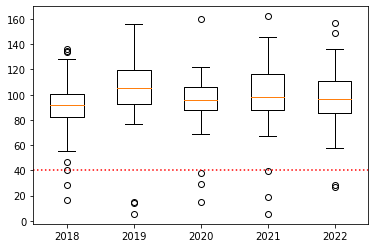

In [40]:
plt.boxplot(traj_time_5y,labels=years);
plt.axhline(y=40, color='r', linestyle=':')

On constate un gros écart entre les outliers inf et les boxplots. En effet, ce sont des trajets de moins de 40h ce qui ne parait pas réaliste. Pour faire le trajet T-M en 40h, il faudrait la vitesse tailwind autour de 28m/s (103km/h) tout au long de trajet. Vitesse trop élevée, pas réaliste et potentiellement dangereuse pour commander l'UAV. (??) De plus, les vitesses max obtenues ne semblent pas être aussi élevées.

Donc on supprime tous les trajets <40h car ils ne sont pas pertinents pour notre étude : conditions extrêmes et ponctuelles, nous on s'intéresse aux conditions qui sont consistentes donc pas pertinent pour notre étude)

Quant aux outliers sup, écart petit entre les outliers et la distribution de boxplot. De plus, les outliers sup sont des trajets >380h (qui ne sont pas affichés). Donc on les garde car ils peuvent nous apporter les infos sur les cond défavorables

In [41]:
u_v_time_opt_2018 = {k: v for k, v in u_v_time_opt_2018_base.items() if v[-1] > 40} #final data
u_v_time_opt_2019 = {k: v for k, v in u_v_time_opt_2019_base.items() if v[-1] > 40} #final data
u_v_time_opt_2020 = {k: v for k, v in u_v_time_opt_2020_base.items() if v[-1] > 40} #final data
u_v_time_opt_2021 = {k: v for k, v in u_v_time_opt_2021_base.items() if v[-1] > 40} #final data
u_v_time_opt_2022 = {k: v for k, v in u_v_time_opt_2022_base.items() if v[-1] > 40} #final data

### Extracting data of shortest and longest trajectory times 

In [42]:
data_best_2018,data_worst_2018=get_periods(u_v_time_opt_2018,8) #we 15% of shortest and longest trajectory times

In [43]:
windspeed_2018,winddir_2018,windspeed_best_2018,winddir_best_2018,windspeed_worst_2018,winddir_worst_2018=get_wind_cond(2018,u_v_time_opt_2018,8)
traj_time_2018,traj_time_best_2018,traj_time_worst_2018=get_traj_time(u_v_time_opt_2018,8)


In [44]:
data_best_2019,data_worst_2019=get_periods(u_v_time_opt_2019,8) #we 15% of shortest and longest trajectory times

In [45]:
windspeed_2019,winddir_2019,windspeed_best_2019,winddir_best_2019,windspeed_worst_2019,winddir_worst_2019=get_wind_cond(2019,u_v_time_opt_2019,8)
traj_time_2019,traj_time_best_2019,traj_time_worst_2019=get_traj_time(u_v_time_opt_2019,8)


In [46]:
data_best_2020,data_worst_2020=get_periods(u_v_time_opt_2020,8)

In [47]:
windspeed_2020,winddir_2020,windspeed_best_2020,winddir_best_2020,windspeed_worst_2020,winddir_worst_2020=get_wind_cond(2020,u_v_time_opt_2020,8)
traj_time_2020,traj_time_best_2020,traj_time_worst_2020=get_traj_time(u_v_time_opt_2020,8)


In [48]:
data_best_2021,data_worst_2021=get_periods(u_v_time_opt_2021,8)

In [49]:
windspeed_2021,winddir_2021,windspeed_best_2021,winddir_best_2021,windspeed_worst_2021,winddir_worst_2021=get_wind_cond(2021,u_v_time_opt_2021,8)
traj_time_2021,traj_time_best_2021,traj_time_worst_2021=get_traj_time(u_v_time_opt_2021,8)


In [50]:
data_best_2022,data_worst_2022=get_periods(u_v_time_opt_2022,8) #we 15% of shortest and longest trajectory times

In [79]:
windspeed_2022,winddir_2022,windspeed_best_2022,winddir_best_2022,windspeed_worst_2022,winddir_worst_2022=get_wind_cond(2022,u_v_time_opt_2022,8)
traj_time_2022,traj_time_best_2022,traj_time_worst_2022=get_traj_time(u_v_time_opt_2022,8)


## Statistical analysis over 5 years

In [52]:
windspeed_5y=[windspeed_2018,windspeed_2019,windspeed_2020,windspeed_2021,windspeed_2022]
windspeed_best_5y=[windspeed_best_2018,windspeed_best_2019,windspeed_best_2020,windspeed_best_2021,windspeed_best_2022]
windspeed_worst_5y=[windspeed_worst_2018,windspeed_worst_2019,windspeed_worst_2020,windspeed_worst_2021,windspeed_worst_2022]


traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]

years=[2018,2019,2020,2021,2022]



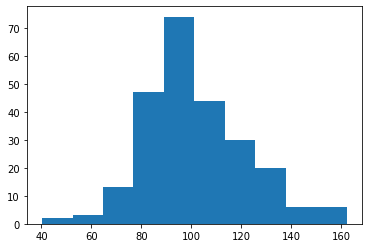

In [56]:
#histogramme des temps de traj de 2018-2022
plt.hist(traj_time_5y);

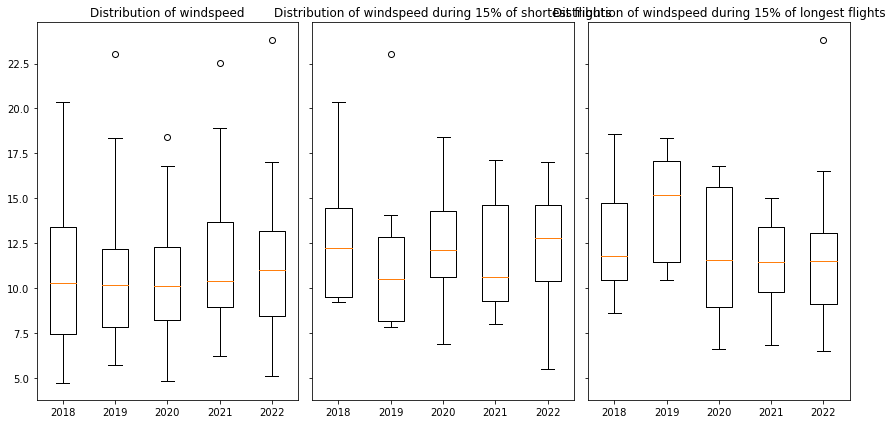

In [53]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 6))

axes[0].boxplot(windspeed_5y,labels=years)
axes[0].set_title('Distribution of windspeed')

axes[1].boxplot(windspeed_best_5y,labels=years)
axes[1].set_title('Distribution of windspeed during 15% of shortest flights')

axes[2].boxplot(windspeed_worst_5y,labels=years)
axes[2].set_title('Distribution of windspeed during 15% of longest flights')

# Show the plot
plt.tight_layout()
plt.show()

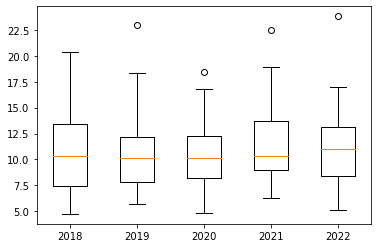

In [42]:
windspeed_2018=get_windspeed_days(u_v_time_opt_2018)
windspeed_2019=get_windspeed_days(u_v_time_opt_2019)
windspeed_2020=get_windspeed_days(u_v_time_opt_2020)
windspeed_2021=get_windspeed_days(u_v_time_opt_2021)
windspeed_2022=get_windspeed_days(u_v_time_opt_2022)
windspeed_5y=[windspeed_2018,windspeed_2019,windspeed_2020,windspeed_2021,windspeed_2022]
plt.boxplot(windspeed_5y,labels=years);


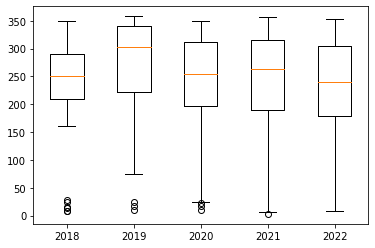

In [44]:
winddir_2018=get_winddir_days(u_v_time_opt_2018)
winddir_2019=get_winddir_days(u_v_time_opt_2019)
winddir_2020=get_winddir_days(u_v_time_opt_2020)
winddir_2021=get_winddir_days(u_v_time_opt_2021)
winddir_2022=get_winddir_days(u_v_time_opt_2022)
winddir_5y=[winddir_2018,winddir_2019,winddir_2020,winddir_2021,winddir_2022]
plt.boxplot(winddir_5y,labels=years);


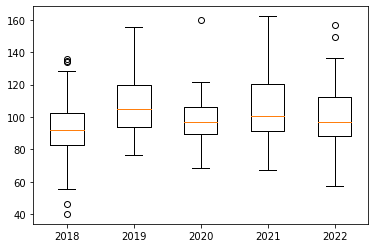

In [47]:
traj_time_2018=get_traj_time(u_v_time_opt_2018,8)[0]
traj_time_2019=get_traj_time(u_v_time_opt_2019,8)[0]
traj_time_2020=get_traj_time(u_v_time_opt_2020,8)[0]
traj_time_2021=get_traj_time(u_v_time_opt_2021,8)[0]
traj_time_2022=get_traj_time(u_v_time_opt_2022,8)[0]
traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]
plt.boxplot(traj_time_5y,labels=years);

In [54]:
winddir_5y=list(winddir_2018)+list(winddir_2019)+list(winddir_2020)+list(winddir_2021)+list(winddir_2022)
winddir_best_5y=list(winddir_best_2018)+list(winddir_best_2019)+list(winddir_best_2020)+list(winddir_best_2021)+list(winddir_best_2022)
winddir_worst_5y=list(winddir_worst_2018)+list(winddir_worst_2019)+list(winddir_worst_2020)+list(winddir_worst_2021)+list(winddir_worst_2022)

traj_time_5y=traj_time_2018+traj_time_2019+traj_time_2020+traj_time_2021+traj_time_2022
traj_time_best_5y=traj_time_best_2018+traj_time_best_2019+traj_time_best_2020+traj_time_best_2021+traj_time_best_2022

windspeed_5y=list(windspeed_2018)+list(windspeed_2019)+list(windspeed_2020)+list(windspeed_2021)+list(windspeed_2022)
windspeed_best_5y=list(windspeed_best_2018)+list(windspeed_best_2019)+list(windspeed_best_2020)+list(windspeed_best_2021)+list(windspeed_best_2022)
windspeed_worst_5y=list(windspeed_worst_2018)+list(windspeed_worst_2019)+list(windspeed_worst_2020)+list(windspeed_worst_2021)+list(windspeed_worst_2022)




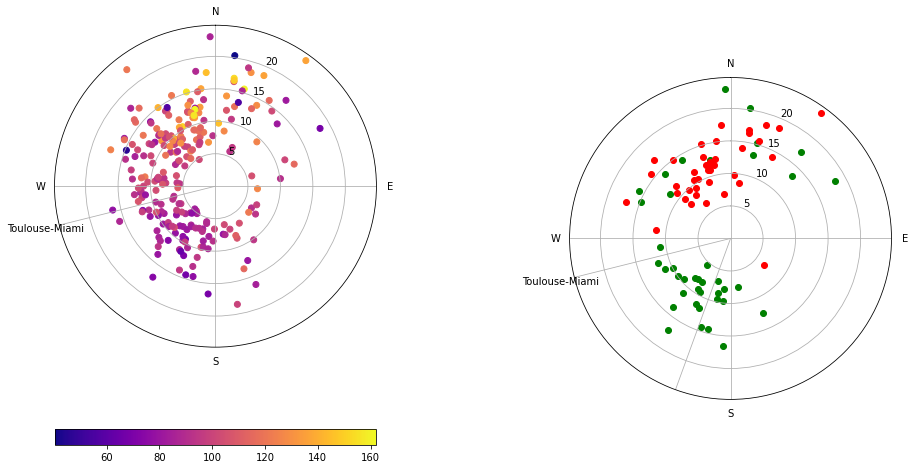

In [55]:
#wind fields (directions = angles, windspeed = length) during trajectories 2018-2022
#left = all trajectories colored by their traj time
#right = shortest 15% traj (green) and 15% longest (red)
winddir_5y_rad=np.radians(winddir_5y)
winddir_best_5y_rad=np.radians(winddir_best_5y)
winddir_worst_5y_rad=np.radians(winddir_worst_5y)


indices=windspeed_5y
indices_best=windspeed_best_5y
indices_worst=windspeed_worst_5y

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)


c0 = axes[0].scatter(winddir_5y_rad, indices, c=traj_time_5y, cmap='plasma')
axes[0].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c1=axes[1].scatter(winddir_best_5y_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c2=axes[1].scatter(winddir_worst_5y_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,200,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','','Toulouse-Miami', 'W'])
fig.colorbar(c0, ax=axes[0], orientation='horizontal')




plt.subplots_adjust(wspace=0.6)
plt.show()

In [57]:
# Meilleures periodes

In [58]:
dates_best_2022=[key for key in data_best_2022.keys()]
dates_best_2021=[key for key in data_best_2021.keys()]
dates_best_2020=[key for key in data_best_2020.keys()]
dates_best_2019=[key for key in data_best_2019.keys()]
dates_best_2018=[key for key in data_best_2018.keys()]
dates_best_5y=dates_best_2022+ dates_best_2021+   dates_best_2020+    dates_best_2019+ dates_best_2018  


In [59]:
data_best_5y={**data_best_2018,**data_best_2019,**data_best_2020,**data_best_2021,**data_best_2022}
date_traj_best_5y=get_date_time(data_best_5y)

In [60]:
data_5y={**u_v_time_opt_2018,**u_v_time_opt_2019,**u_v_time_opt_2020,**u_v_time_opt_2021,**u_v_time_opt_2022}
date_traj_5y=get_date_time(data_5y)

In [61]:
data_worst_5y={**data_worst_2018,**data_worst_2019,**data_worst_2020,**data_worst_2021,**data_worst_2022}
date_traj_worst_5y=get_date_time(data_worst_5y)

In [62]:
date_traj_best_5y.keys()

dict_keys(['01/18', '01/31', '02/21', '02/26', '03/12', '03/30', '04/05', '04/06', '04/27', '05/07', '06/04', '06/08', '06/13', '06/14', '06/20', '06/21', '07/02', '07/11', '07/13', '08/02', '08/08', '08/16', '08/26', '09/02', '09/07', '09/09', '09/10', '09/13', '09/14', '09/16', '09/20', '09/21', '09/26', '10/01', '10/07', '10/15', '10/21', '10/28', '11/25', '12/05'])

In [63]:
date_traj_worst_5y.keys()

dict_keys(['01/01', '01/10', '01/11', '01/14', '01/24', '01/25', '01/28', '02/01', '02/03', '02/08', '02/11', '02/12', '03/02', '03/04', '03/15', '03/19', '03/23', '03/29', '04/02', '04/08', '04/11', '04/16', '04/20', '04/22', '05/06', '05/18', '05/24', '06/06', '10/24', '11/01', '11/07', '11/26', '12/07', '12/12', '12/16', '12/17', '12/19', '12/21', '12/24', '12/28'])

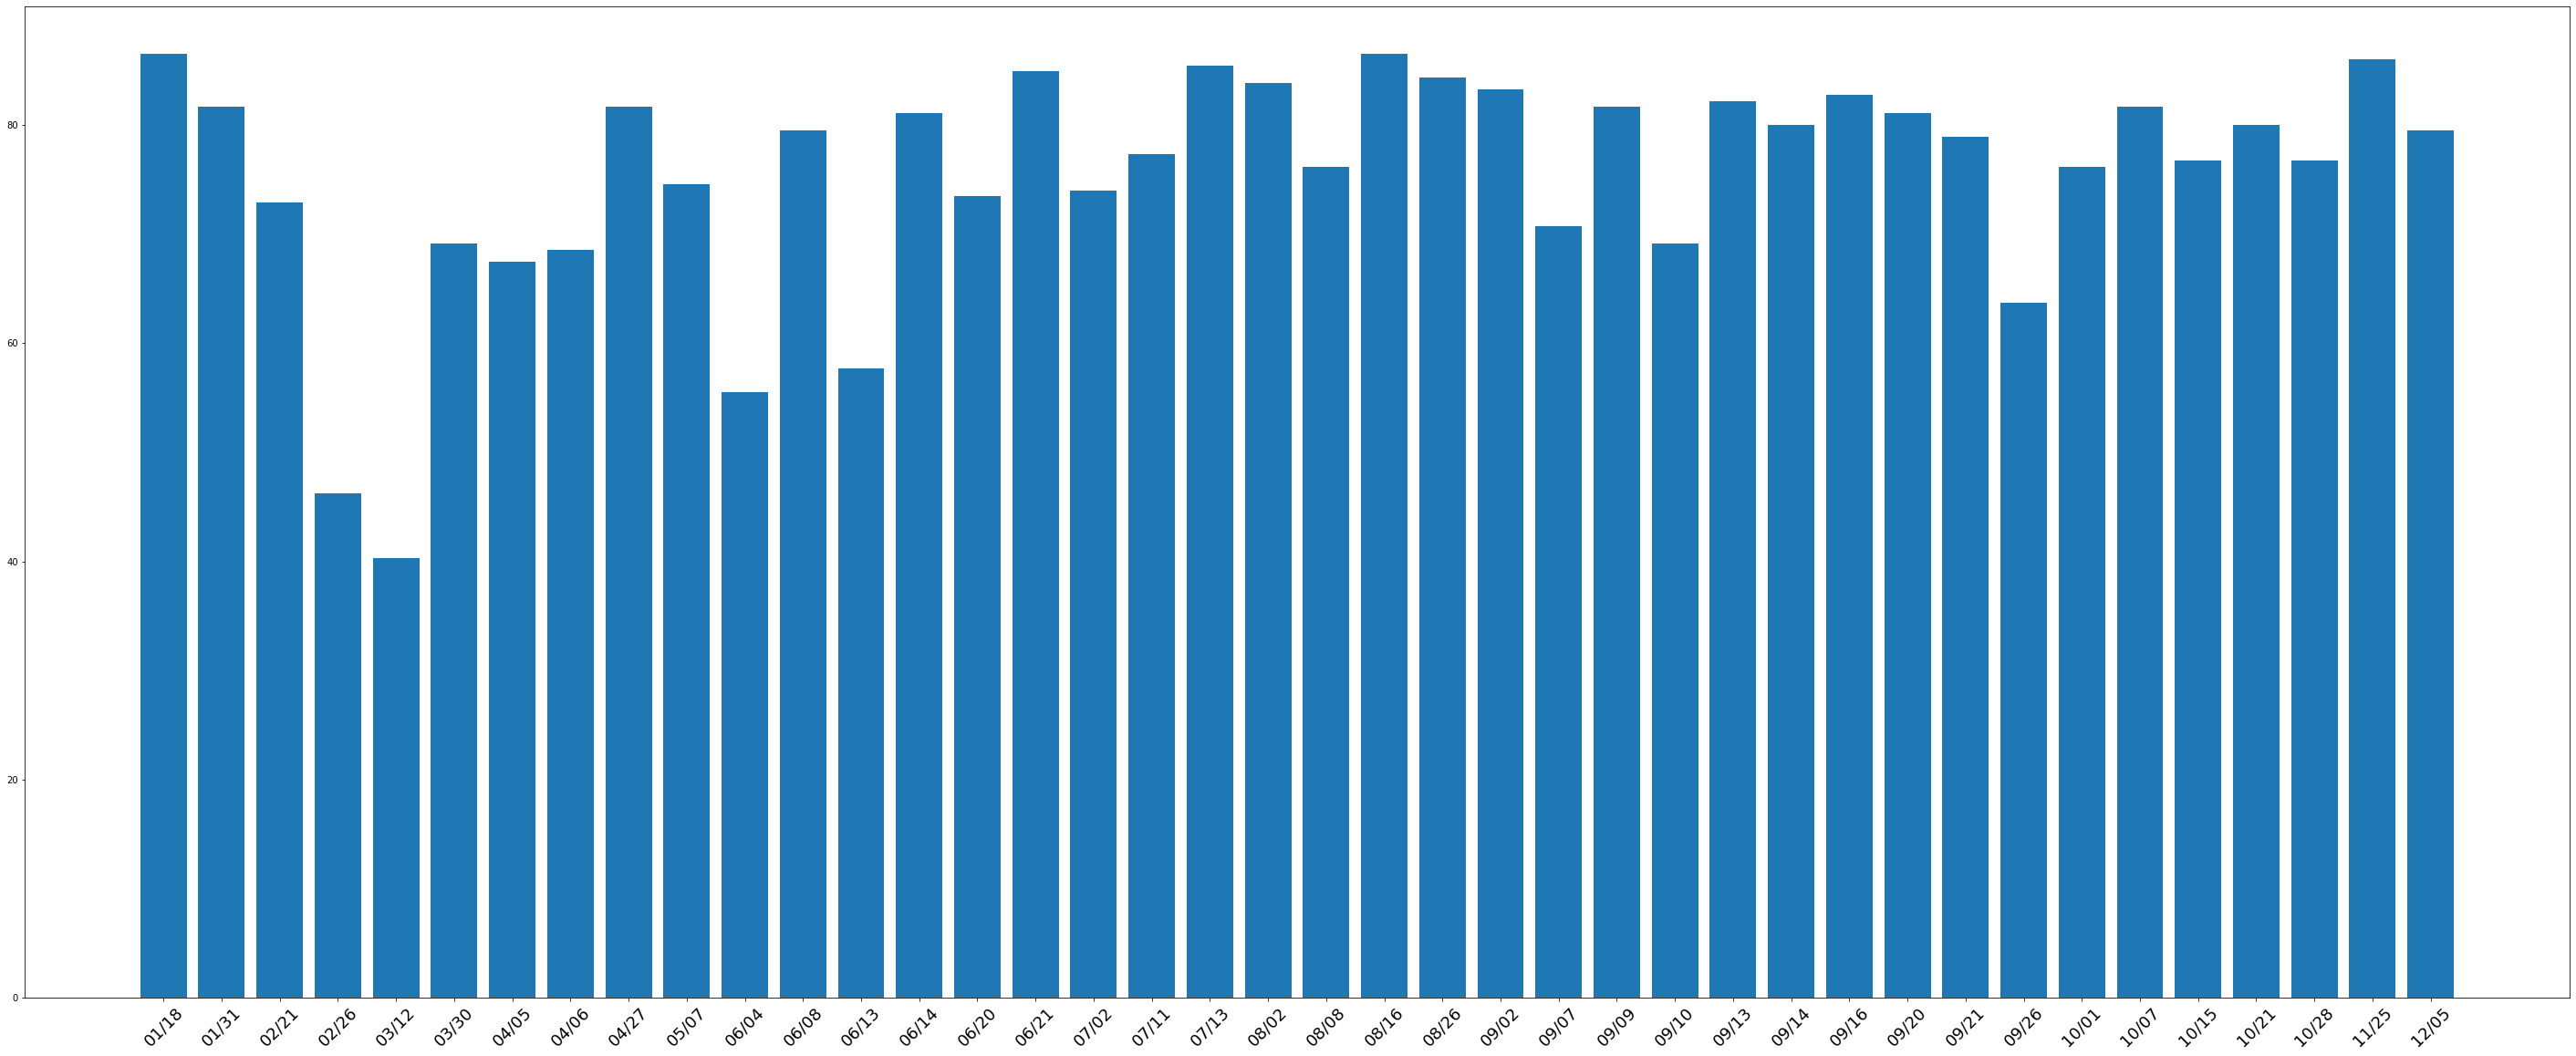

In [64]:
#Hist of shortest flights 
dates_best_5y = list(date_traj_best_5y.keys())
traj_time_best_5y = [v[-1] for v in date_traj_best_5y.values()]

plt.figure(figsize=(50, 20))
plt.bar(dates_best_5y, traj_time_best_5y)

plt.xticks(rotation=45,fontsize=18)
plt.show()

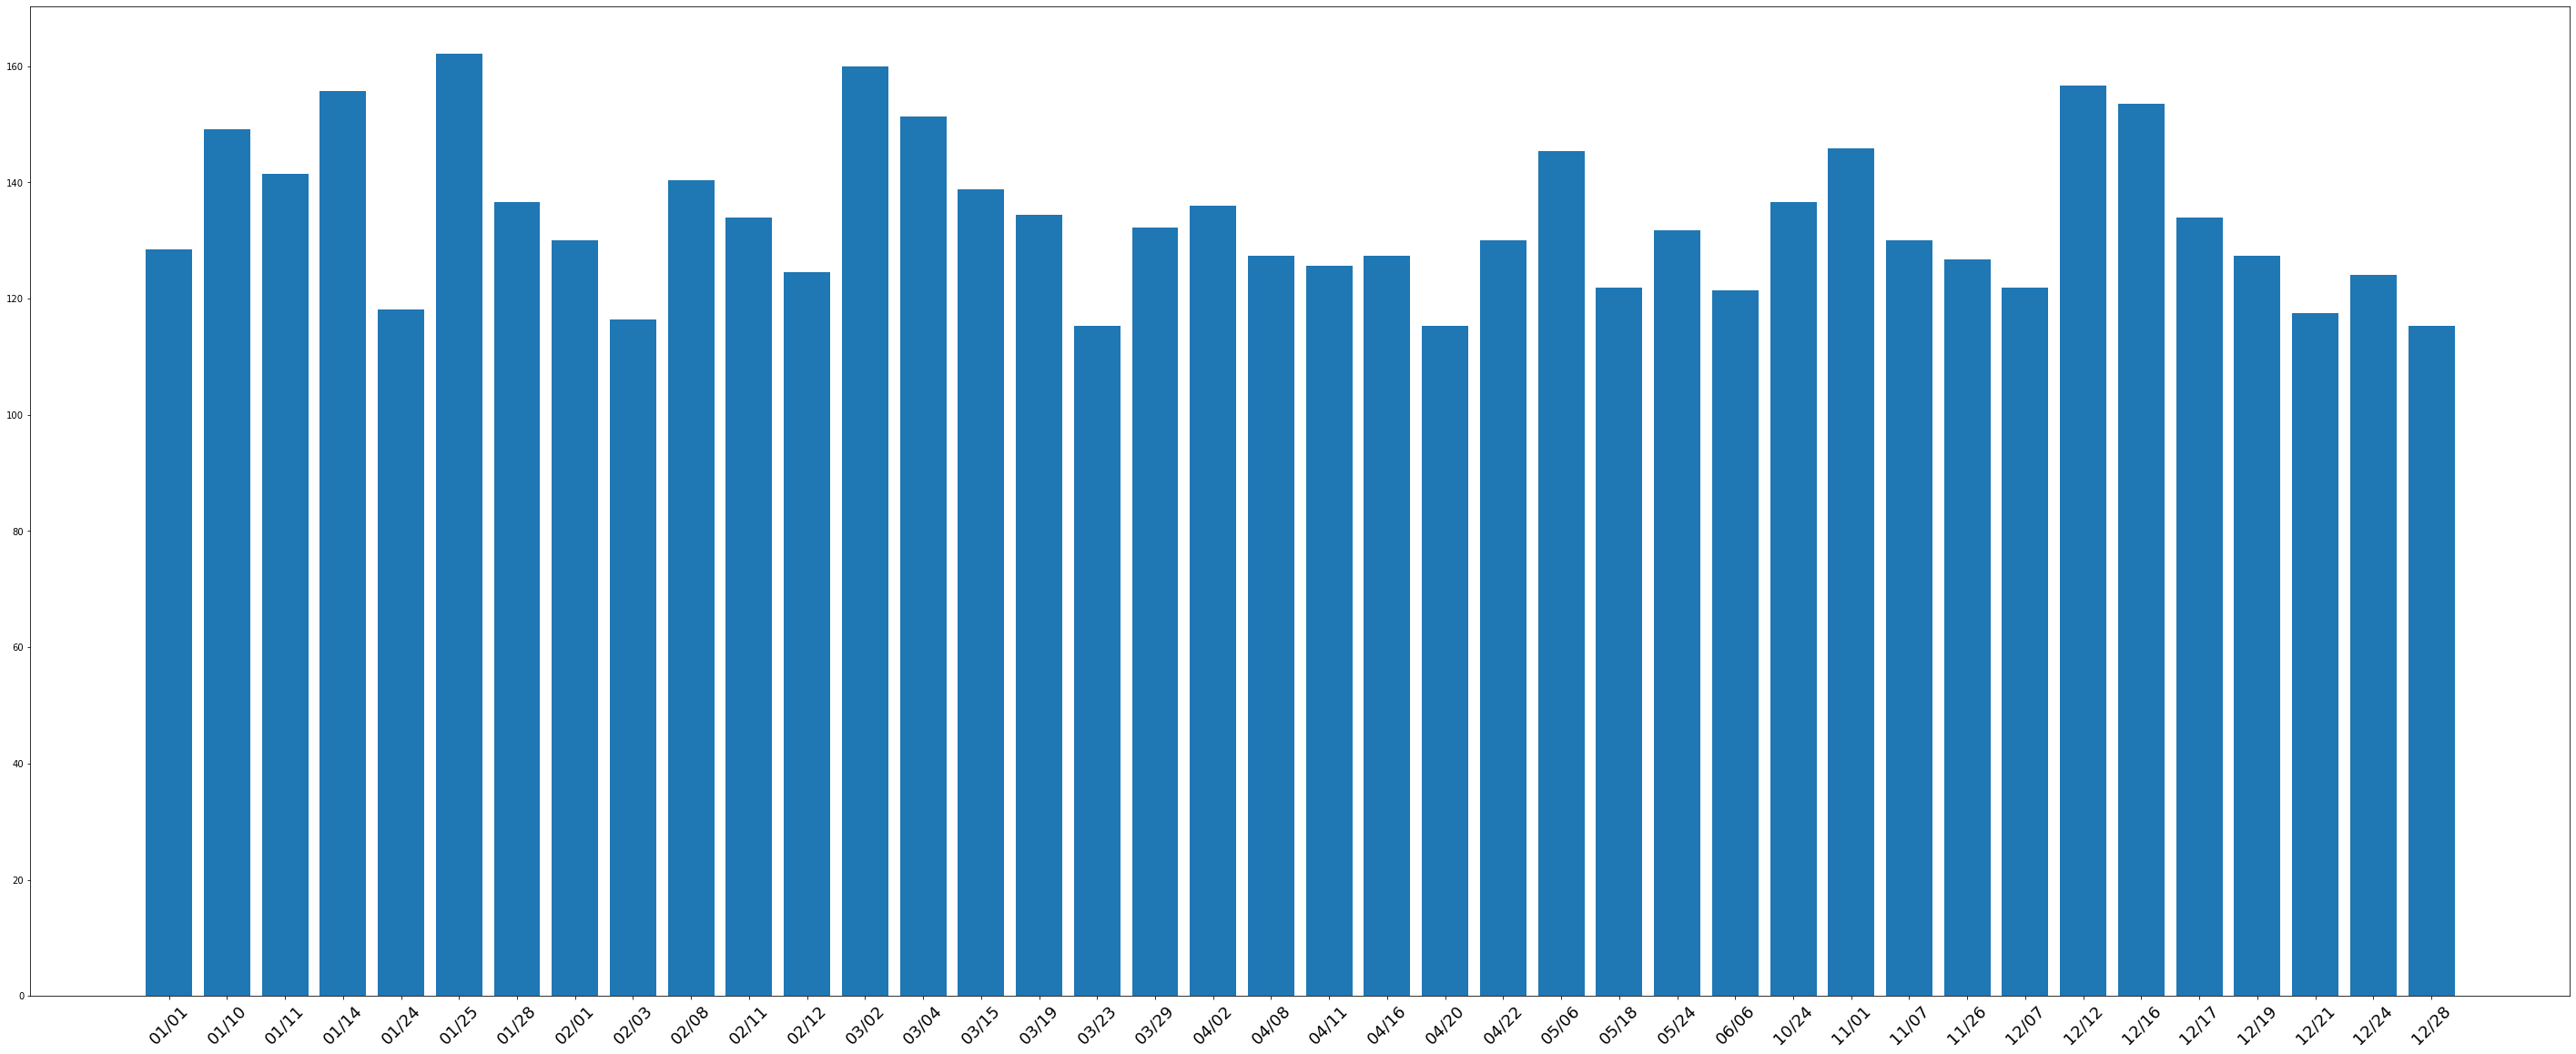

In [65]:
#Hist of longest flights 
dates_worst_5y = list(date_traj_worst_5y.keys())
traj_time_worst_5y = [v[-1] for v in date_traj_worst_5y.values()]

plt.figure(figsize=(50, 20))
plt.bar(dates_worst_5y, traj_time_worst_5y)

plt.xticks(rotation=45,fontsize=18)
plt.show()

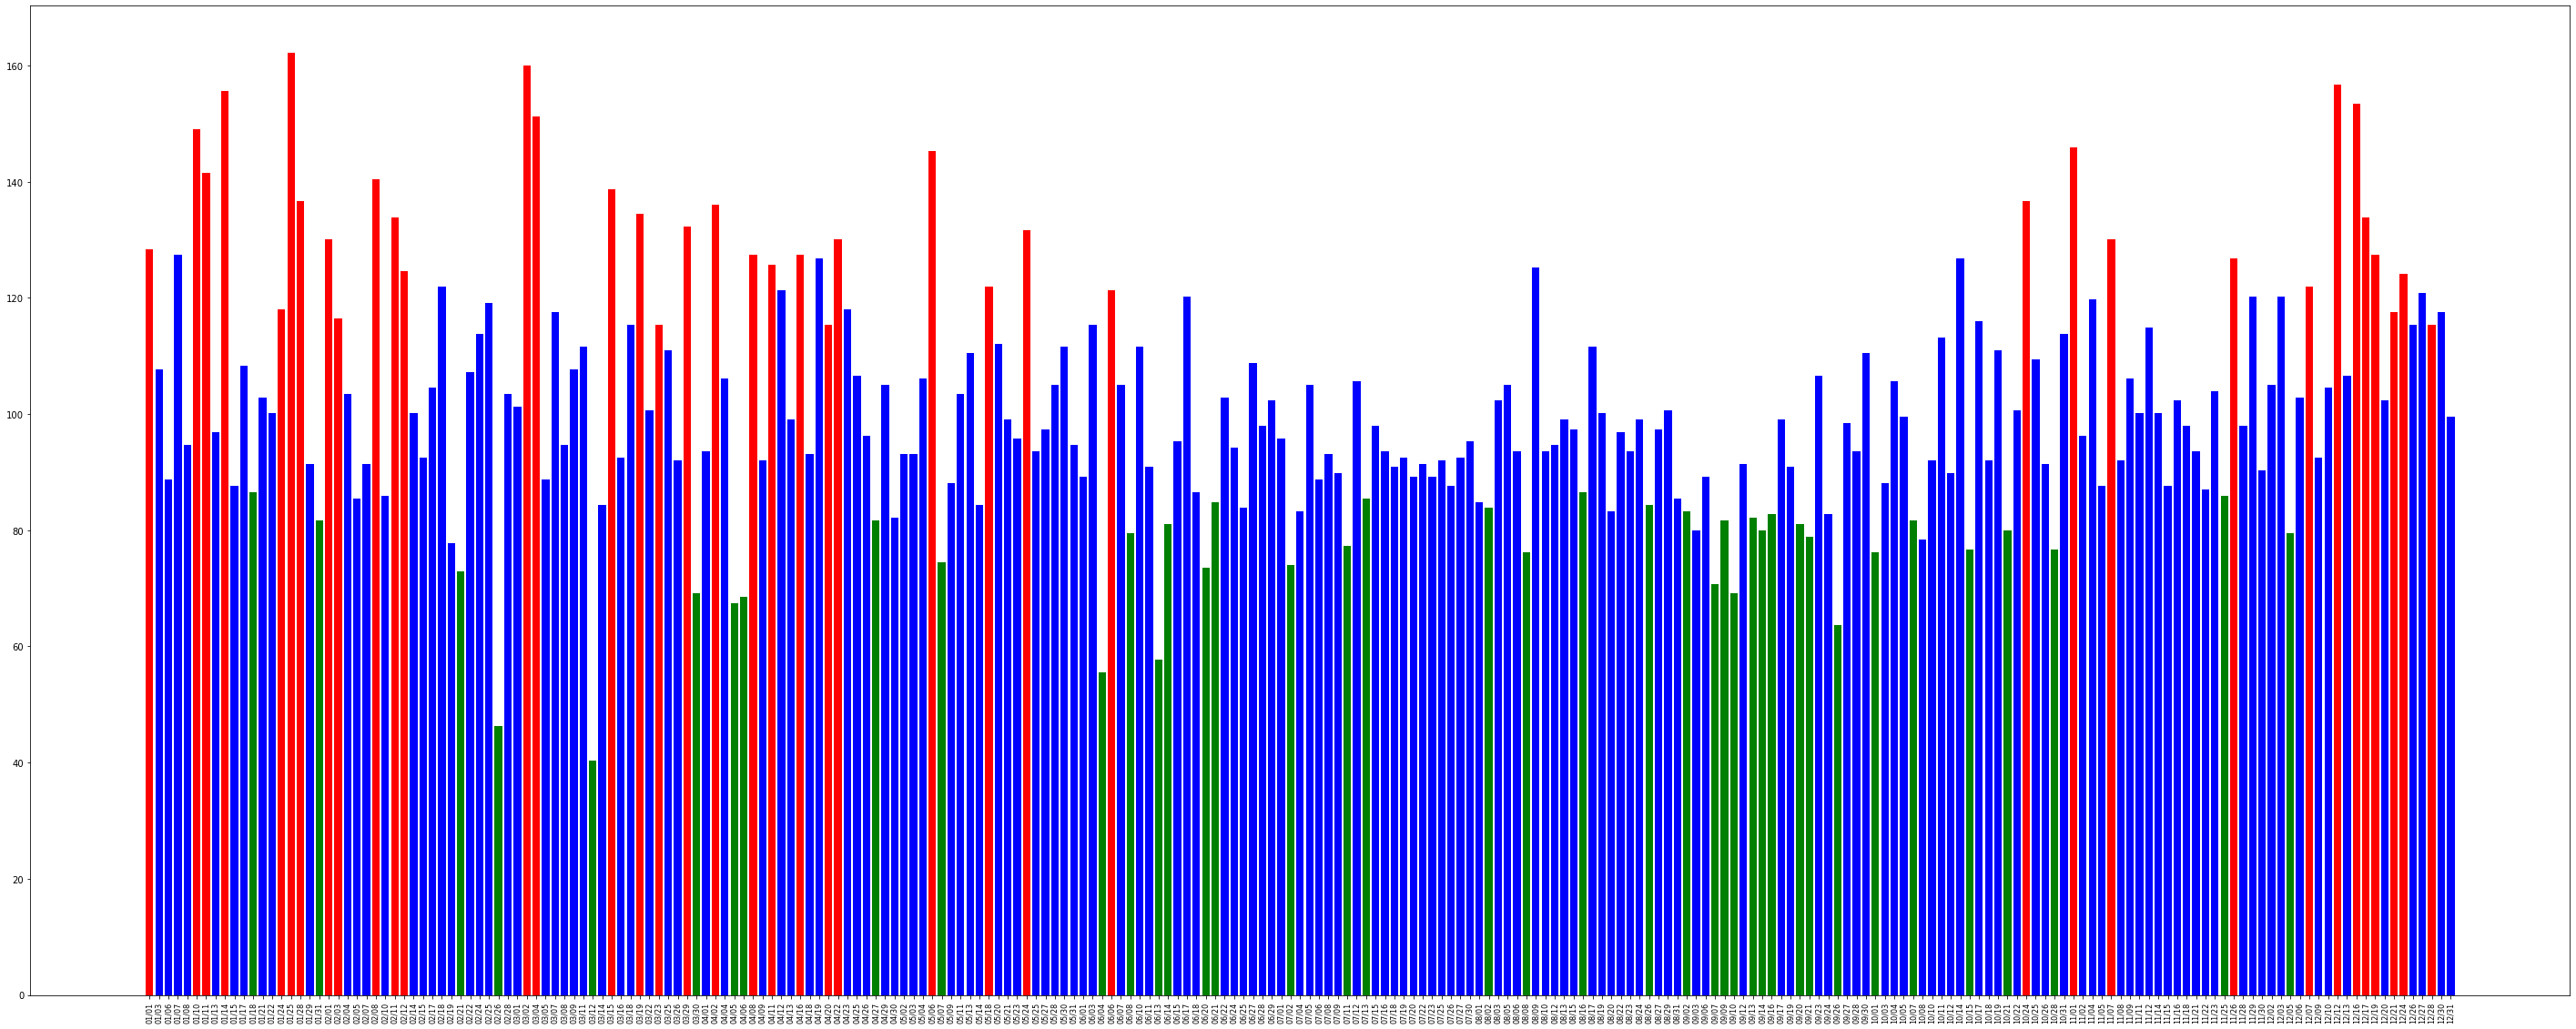

In [66]:
#ouvrir l'image dans nouvelle fenetre pour lire les dates
dates_5y = list(date_traj_5y.keys())
traj_time_5y = [v[-1] for v in date_traj_5y.values()]

colors = ['red' if date_5y in dates_worst_5y else 'green' if date_5y in dates_best_5y else 'blue' for date_5y in dates_5y]

plt.figure(figsize=(50, 20))
plt.bar(dates_5y, traj_time_5y, color=colors)
plt.xticks(rotation=90,fontsize=8)

plt.show()


In [67]:
u_v_time_opt_5y={**u_v_time_opt_2018,**u_v_time_opt_2019,**u_v_time_opt_2020,**u_v_time_opt_2021,**u_v_time_opt_2022}
data_5y=get_date_time(u_v_time_opt_5y)
df_5y = pd.DataFrame(data_5y).T
df_5y = df_5y.rename(columns={0: 'avg_traj_windspeed', 1: 'avg_traj_winddir', 2: 'traj_time'})
df_5y['date']=list(data_5y.keys())
df_5y

,avg_traj_windspeed,avg_traj_winddir,traj_time,date
01/01,13.977247,27.008746,128.438763,01/01
01/03,8.141550,272.089640,107.757946,01/03
01/06,9.176925,244.751795,88.709824,01/06
01/07,9.201389,340.178449,127.350299,01/07
01/08,14.054807,203.244348,94.696376,01/08
...,...,...,...,...
12/26,12.589122,74.336173,115.377194,12/26
12/27,22.551342,322.743564,120.819515,12/27
12/28,15.762164,308.684564,115.377194,12/28
12/30,8.860590,343.287734,117.554122,12/30


In [68]:
#save the dataframe
df_5y.to_csv('data_5y_TM.csv', index=False)

In [4]:
#read dataframe directly to avoid rerunning dict creation
df_5y = pd.read_csv('data_5y_TM.csv', sep = ",")
df_5y

,avg_traj_windspeed,avg_traj_winddir,traj_time,date
0,13.977247,27.008746,128.438763,01/01
1,8.141550,272.089640,107.757946,01/03
2,9.176925,244.751795,88.709824,01/06
3,9.201389,340.178449,127.350299,01/07
4,14.054807,203.244348,94.696376,01/08
...,...,...,...,...
240,12.589122,74.336173,115.377194,12/26
241,22.551342,322.743564,120.819515,12/27
242,15.762164,308.684564,115.377194,12/28
243,8.860590,343.287734,117.554122,12/30


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd136c2a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd136c2c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccff2f90a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd136c2e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccff307490>],
 'means': []}

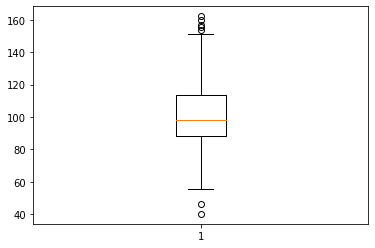

In [70]:
plt.boxplot(df_5y['traj_time'])

In [5]:
df_5y['date_dt'] = pd.to_datetime(df_5y['date'], format='%m/%d')
df_5y['semi_month'] = df_5y['date_dt'].apply(lambda dt: f"{dt.strftime('%B')}_1st_half" if dt.day <= 15 else f"{dt.strftime('%B')}_2nd_half")
df_5y = df_5y.drop(columns='date_dt')
df_5y




,avg_traj_windspeed,avg_traj_winddir,traj_time,date,semi_month
0,13.977247,27.008746,128.438763,01/01,January_1st_half
1,8.141550,272.089640,107.757946,01/03,January_1st_half
2,9.176925,244.751795,88.709824,01/06,January_1st_half
3,9.201389,340.178449,127.350299,01/07,January_1st_half
4,14.054807,203.244348,94.696376,01/08,January_1st_half
...,...,...,...,...,...
240,12.589122,74.336173,115.377194,12/26,December_2nd_half
241,22.551342,322.743564,120.819515,12/27,December_2nd_half
242,15.762164,308.684564,115.377194,12/28,December_2nd_half
243,8.860590,343.287734,117.554122,12/30,December_2nd_half


In [72]:
df_5y.to_csv('data_5y_TM_semi.csv', index=False)

In [6]:
df_5y = pd.read_csv('data_5y_TM_semi.csv', sep = ",")
df_5y

,avg_traj_windspeed,avg_traj_winddir,traj_time,date,semi_month
0,13.977247,27.008746,128.438763,01/01,January_1st_half
1,8.141550,272.089640,107.757946,01/03,January_1st_half
2,9.176925,244.751795,88.709824,01/06,January_1st_half
3,9.201389,340.178449,127.350299,01/07,January_1st_half
4,14.054807,203.244348,94.696376,01/08,January_1st_half
...,...,...,...,...,...
240,12.589122,74.336173,115.377194,12/26,December_2nd_half
241,22.551342,322.743564,120.819515,12/27,December_2nd_half
242,15.762164,308.684564,115.377194,12/28,December_2nd_half
243,8.860590,343.287734,117.554122,12/30,December_2nd_half


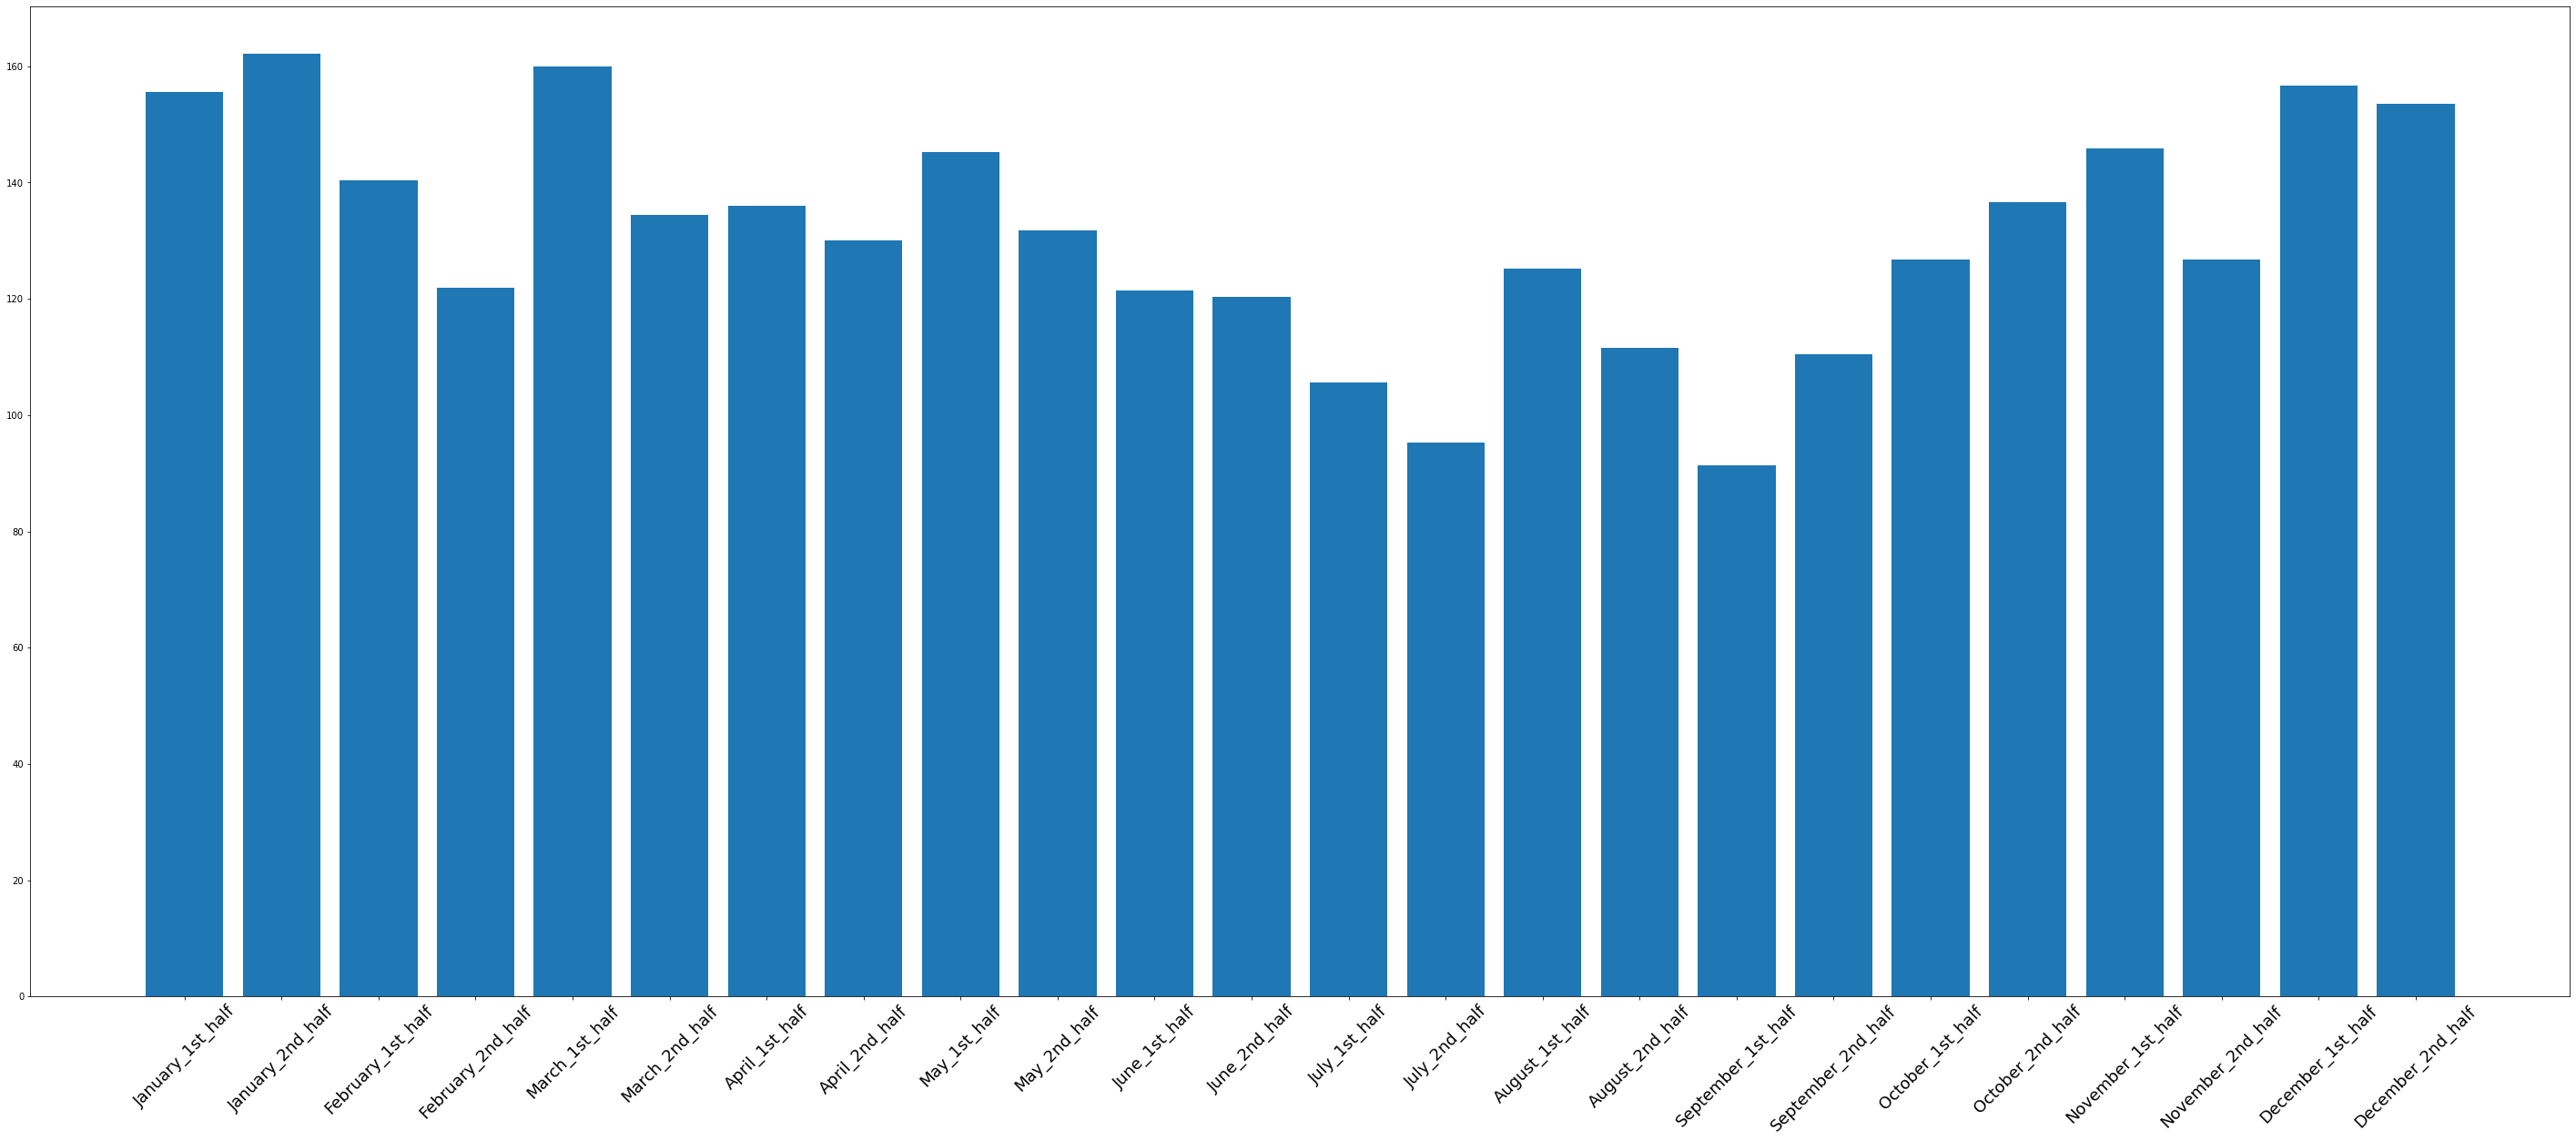

In [74]:
plt.figure(figsize=(50, 20))
plt.bar(df_5y['semi_month'], df_5y['traj_time'])

plt.xticks(rotation=45,fontsize=18)
plt.show()

In [ ]:
df_5y['avg_traj_winddir_rad'] = np.deg2rad(df_5y['avg_traj_winddir'])
df_5y['date'] = '1900/' + df_5y['date']
df_5y['date'] = pd.to_datetime(df_5y['date'], format='%Y/%m/%d')

# Create a polar plot
ax = plt.subplot(111, polar=True)

# Scatter plot - you can choose different colors, markers, sizes
ax.scatter(df_5y['avg_traj_winddir_rad'], df_5y['date'].dt.month + (df_5ydf['date'].dt.day > 15)*0.5, color='blue', s=30)

# Set the direction of the zero angle to North
ax.set_theta_zero_location("N")

# Set the direction of rotation to clockwise
ax.set_theta_direction(-1)

# Set the labels for the cardinal directions
ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

plt.show()

In [3]:
df_5y['semi_month'] = pd.Categorical(df_5y['semi_month'], categories=df_5y['semi_month'].unique(), ordered=True)
df_5y = df_5y.groupby('semi_month',sort=False).agg([ 'mean', 'min', 'max'])

In [12]:
df_5y

avg_traj_windspeed                       avg_traj_winddir  \
                                 mean        min        max             mean   
semi_month                                                                     
January_1st_half            12.616926   8.141550  16.537038       224.627402   
January_2nd_half            12.827820   7.391767  15.853687       247.434633   
February_1st_half           12.759232   9.799712  17.081898       301.555573   
February_2nd_half           11.799107   7.722615  16.249714       244.203340   
March_1st_half              14.547318  10.471115  20.331691       231.288212   
March_2nd_half              13.034271  11.476017  16.639450       266.408325   
April_1st_half              13.351836   8.660603  18.601765       245.547738   
April_2nd_half              11.502535   6.340043  18.342459       203.151631   
May_1st_half                11.732363   8.019143  17.560806       252.761305   
May_2nd_half                 9.608012   6.226153  18.928213       261.729067   
June_1st_half                8.738600   5.712083  14.225047       253.143890   
June_2nd_half                8.825880   4.805062  17.009949       237.348646   
July_1st_half                7.229534   5.614743   9.662645       185.631205   
July_2nd_half                6.980101   5.489873   9.527339       221.983286   
August_1st_half              7.558189   4.809273  11.318922       180.794964   
August_2nd_half              7.515600   4.728520  11.744787       211.460505   
September_1st_half          10.263560   7.460717  17.115216       186.700408   
September_2nd_half           9.011418   5.795704  12.433083       243.014132   
October_1st_half            10.049992   6.486189  16.158718       227.452190   
October_2nd_half            12.469450   6.222664  23.835973       238.080515   
November_1st_half           10.107111   5.959438  13.458560       239.133639   
November_2nd_half           13.537981   9.182259  23.036217       294.569516   
December_1st_half           11.407575   9.400339  13.746276       301.114450   
December_2nd_half           13.376560   8.003144  22.551342       229.333398   

                                             traj_time                         
                           min         max        mean        min         max  
semi_month                                                                     
January_1st_half     10.023516  342.890911  117.771815  87.621360  155.650366  
January_2nd_half      8.252143  351.518857  109.753463  81.634807  162.181150  
February_1st_half   232.693940  343.074772  109.489593  85.444432  140.411869  
February_2nd_half    24.952396  337.761283   96.329073  46.259724  121.907979  
March_1st_half        8.422633  350.238596  108.747458  40.273172  160.004222  
March_2nd_half        7.020771  348.948294  106.971833  69.117470  134.425316  
April_1st_half       23.652941  347.255220  103.730628  67.484774  136.058012  
April_2nd_half        8.905659  338.986222  107.510567  81.634807  130.071460  
May_1st_half         10.016273  355.330707   99.836346  74.559791  145.309957  
May_2nd_half         13.383756  351.017180  106.288519  93.607912  131.704156  
June_1st_half        15.290413  342.688966   91.134130  55.511669  121.363747  
June_2nd_half       144.539633  347.697963   95.512725  73.471327  120.275283  
July_1st_half        23.463951  252.999765   90.540423  74.015559  105.581017  
July_2nd_half       121.134262  356.999889   91.430984  87.621360   95.240609  
August_1st_half      22.485123  308.369954   95.982743  76.192487  125.173371  
August_2nd_half     124.816068  340.491944   94.448998  83.267503  111.567570  
September_1st_half   39.404121  312.609392   80.848694  69.117470   91.430984  
September_2nd_half  114.264321  345.347388   89.847764  63.675150  110.479106  
October_1st_half     93.431351  316.028038   93.459485  76.192487  126.806067  
October_2nd_half     32.059385  349.293027  102.751011  76.736719  136.602244  
November_1st_half 

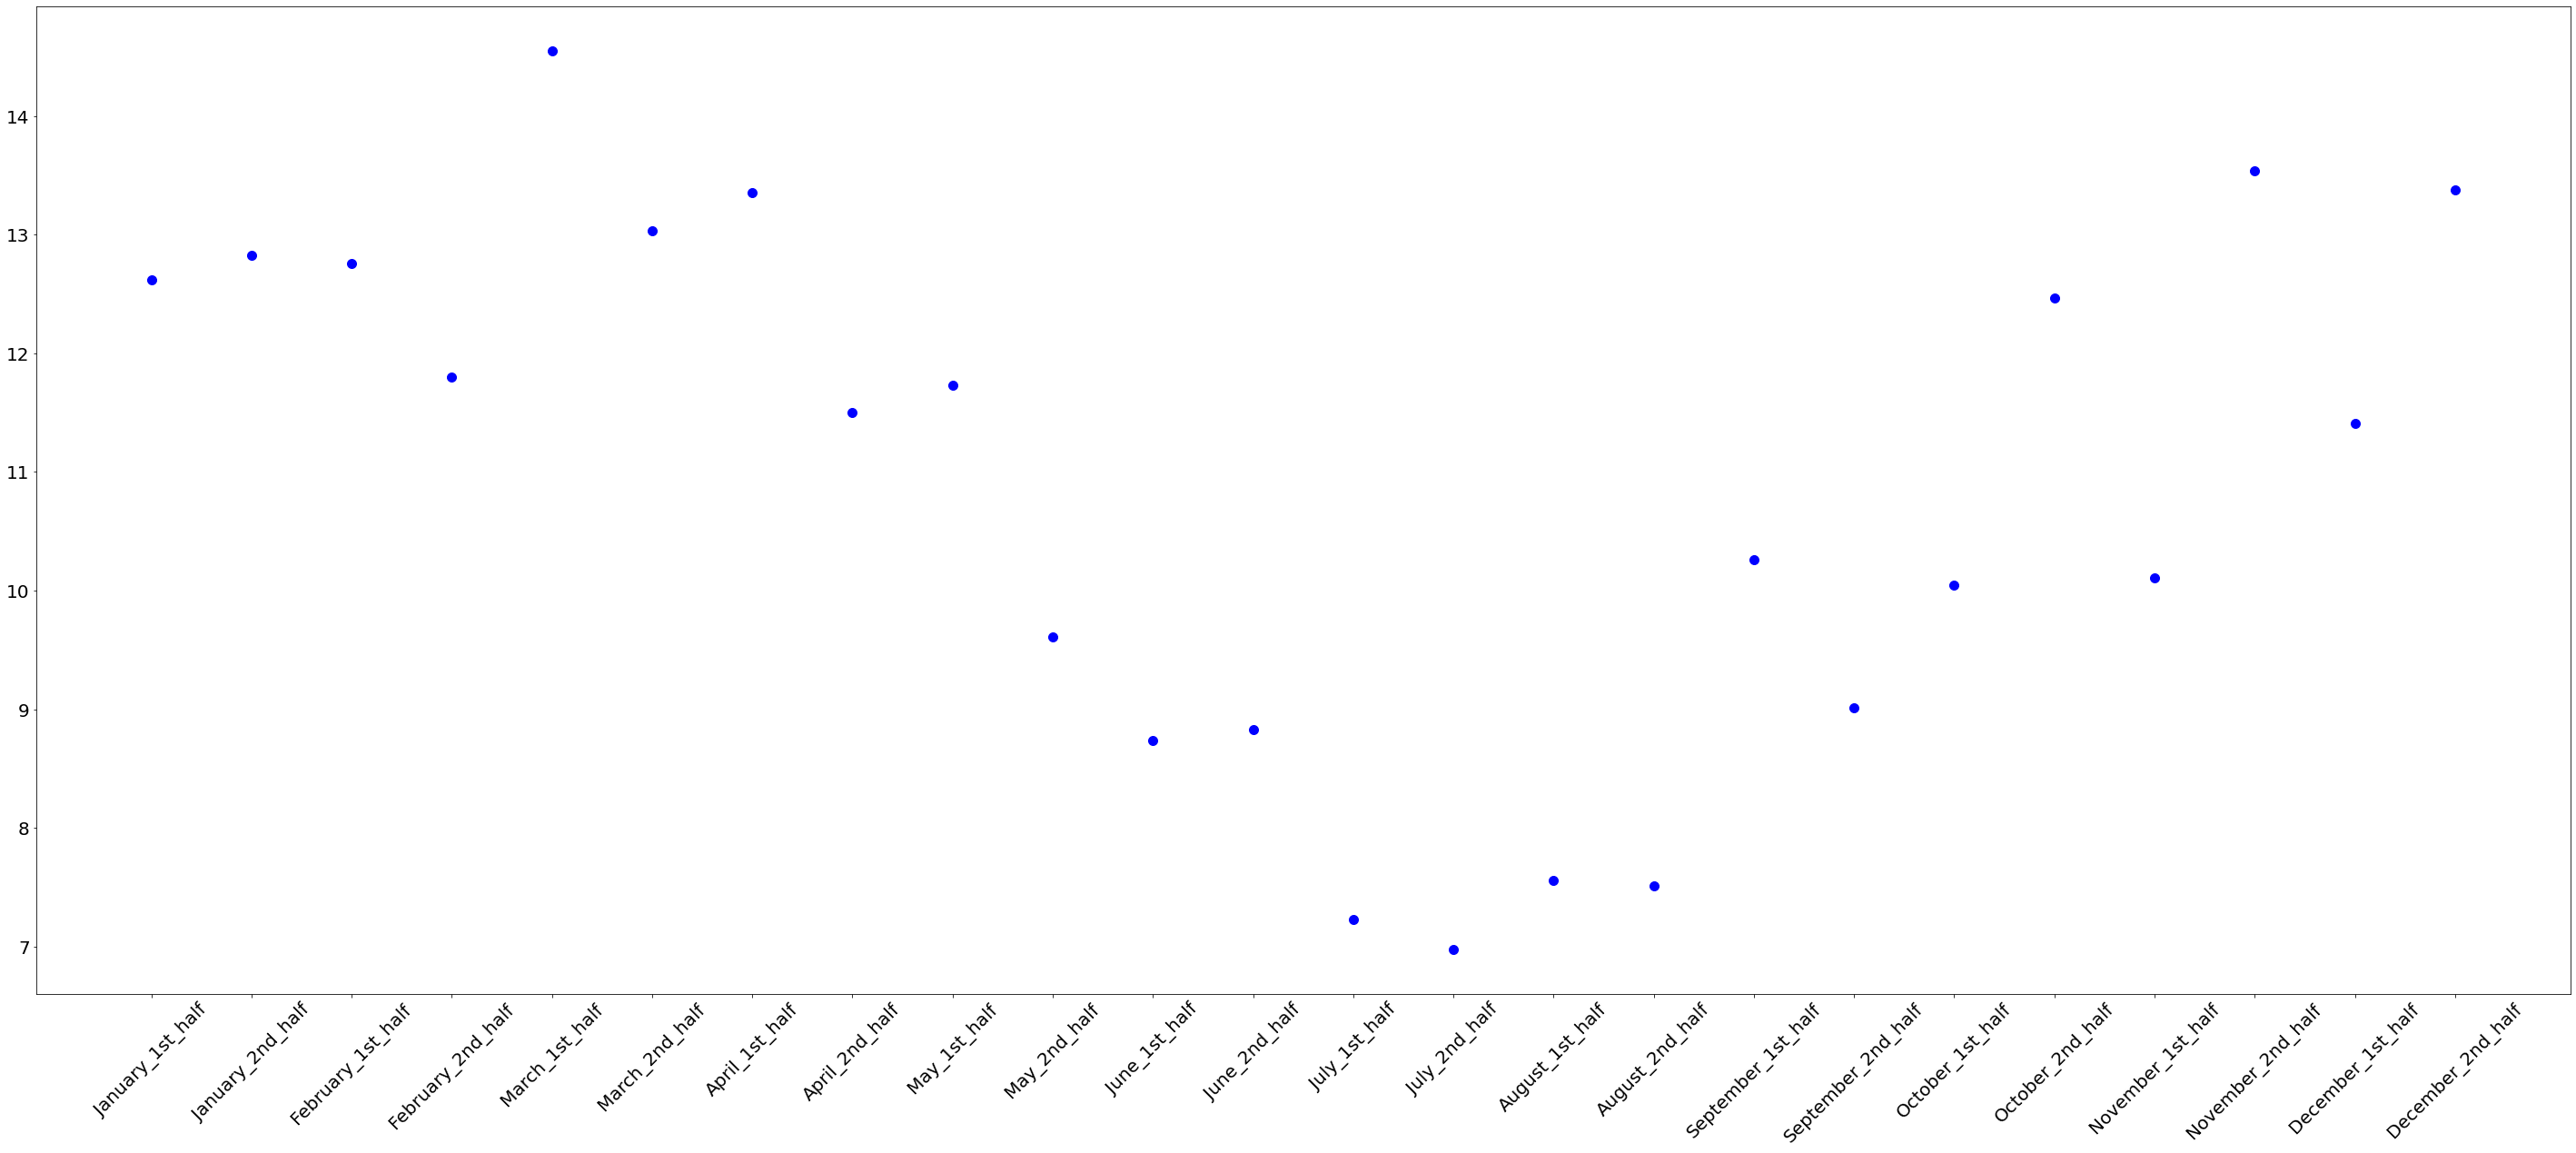

In [23]:
plt.figure(figsize=(50, 20))
plt.scatter(df_5y.index,df_5y['avg_traj_windspeed','mean'],color='blue',s=100)
plt.xticks(rotation=45,fontsize=20);
plt.yticks(fontsize=20);

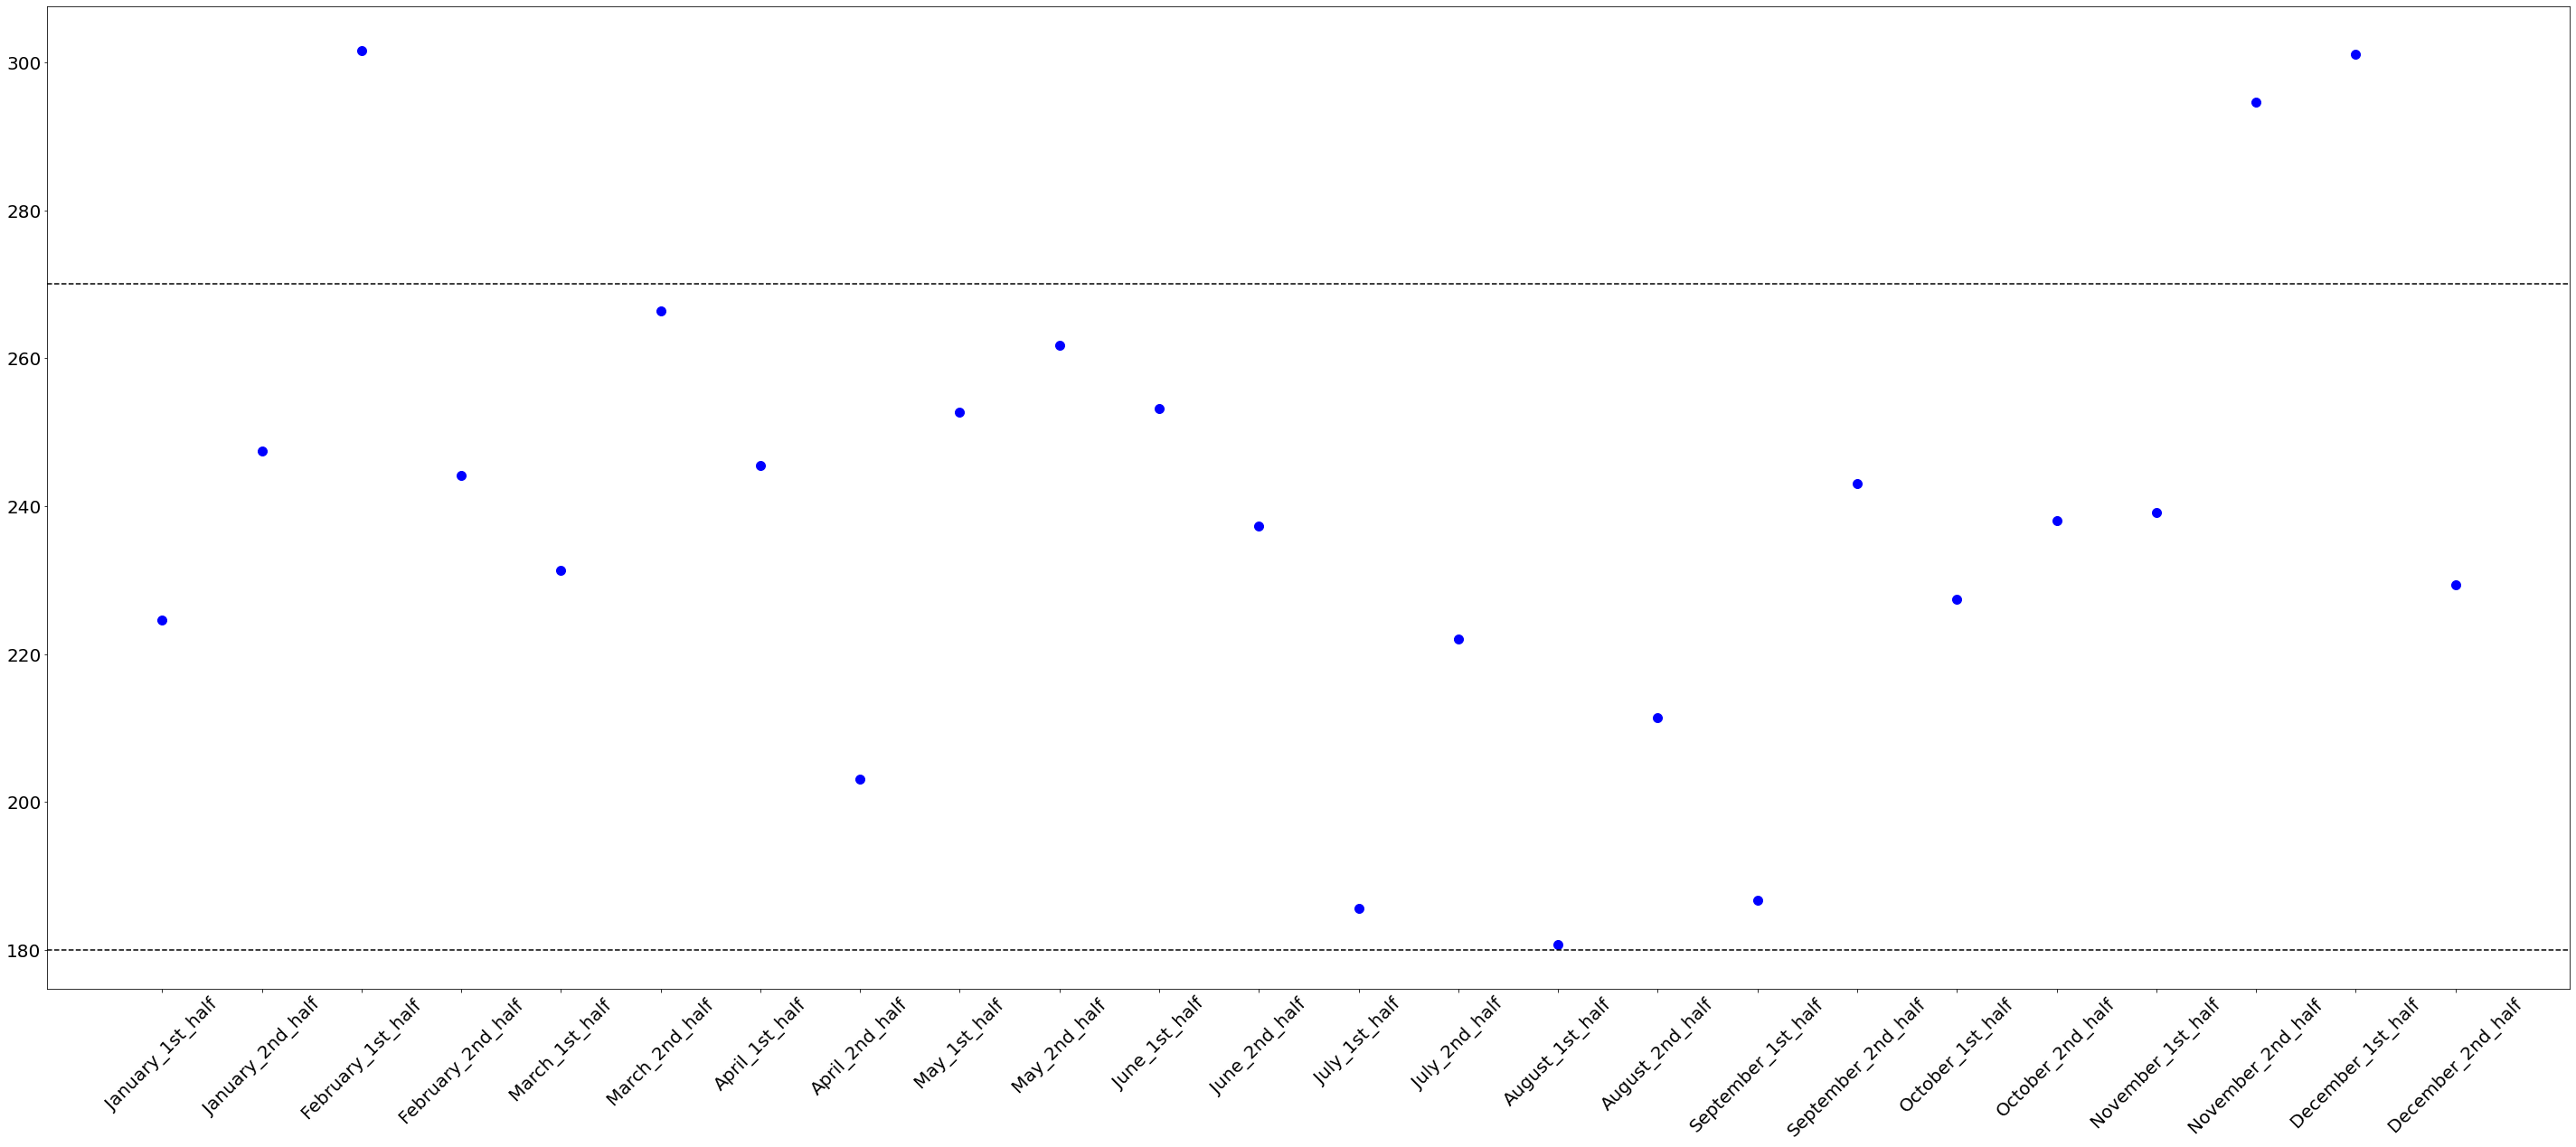

In [26]:
plt.figure(figsize=(50, 20))
plt.scatter(df_5y.index,df_5y['avg_traj_winddir','mean'],color='blue',s=100)
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')

plt.axhline(y=180,color='black',linestyle='--')#S
plt.axhline(y=270,color='black',linestyle='--')#W
plt.xticks(rotation=45,fontsize=20);
plt.yticks(fontsize=20);

In [4]:
df_5y.index = df_5y.index.str.replace('January_1st_half', '01-01-2023')
df_5y.index = df_5y.index.str.replace('January_2nd_half', '01-16-2023')
df_5y.index = df_5y.index.str.replace('February_1st_half', '02-01-2023')
df_5y.index = df_5y.index.str.replace('February_2nd_half', '02-16-2023')
df_5y.index = df_5y.index.str.replace('March_1st_half', '03-01-2023')
df_5y.index = df_5y.index.str.replace('March_2nd_half', '03-16-2023')
df_5y.index = df_5y.index.str.replace('April_1st_half', '04-01-2023')
df_5y.index = df_5y.index.str.replace('April_2nd_half', '04-16-2023')
df_5y.index = df_5y.index.str.replace('May_1st_half', '05-01-2023')
df_5y.index = df_5y.index.str.replace('May_2nd_half', '05-16-2023')
df_5y.index = df_5y.index.str.replace('June_1st_half', '06-01-2023')
df_5y.index = df_5y.index.str.replace('June_2nd_half', '06-16-2023')
df_5y.index = df_5y.index.str.replace('July_1st_half', '07-01-2023')
df_5y.index = df_5y.index.str.replace('July_2nd_half', '08-16-2023')
df_5y.index = df_5y.index.str.replace('August_1st_half', '08-01-2023')
df_5y.index = df_5y.index.str.replace('August_2nd_half', '08-16-2023')
df_5y.index = df_5y.index.str.replace('September_1st_half', '09-01-2023')
df_5y.index = df_5y.index.str.replace('September_2nd_half', '09-16-2023')
df_5y.index = df_5y.index.str.replace('October_1st_half', '10-01-2023')
df_5y.index = df_5y.index.str.replace('October_2nd_half', '10-16-2023')
df_5y.index = df_5y.index.str.replace('November_1st_half', '11-01-2023')
df_5y.index = df_5y.index.str.replace('November_2nd_half', '11-16-2023')
df_5y.index = df_5y.index.str.replace('December_1st_half', '12-01-2023')
df_5y.index = df_5y.index.str.replace('December_2nd_half', '12-16-2023')


In [5]:
df_5y.index = pd.to_datetime(df_5y.index, format='%m-%d-%Y')

In [ ]:
df_5y['avg_traj_winddir_rad','mean'] = np.deg2rad(df_5y['avg_traj_winddir','mean'])

ax = plt.subplot(111, polar=True)
# Convert the index to a DateTimeIndex
# Replace the strings to be in a standard date format


# Convert the index to a DateTimeIndex


ax.scatter(df_5y['avg_traj_winddir_rad','mean'], df_5y.index.month+(df_5y.index.day > 15)*0.5, color='blue', s=30)


# Set the direction of the zero angle to North
ax.set_theta_zero_location("N")

# Set the direction of rotation to clockwise
ax.set_theta_direction(-1)

# Set the labels for the cardinal directions
ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

plt.show()

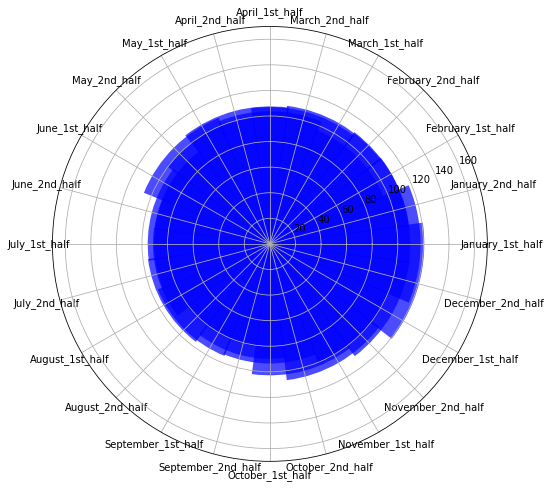

In [22]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['mean'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 170)

plt.show()


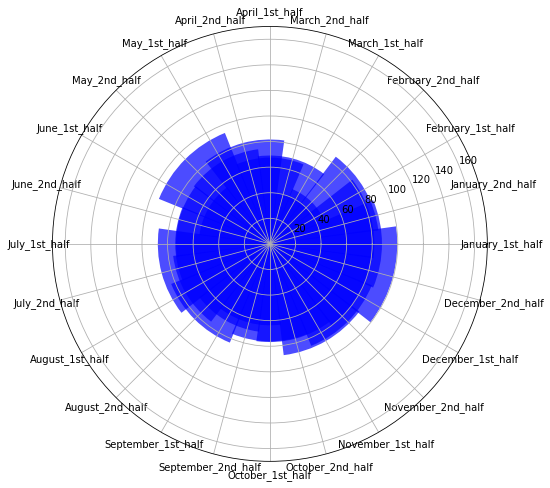

In [8]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['min'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 170)

plt.show()

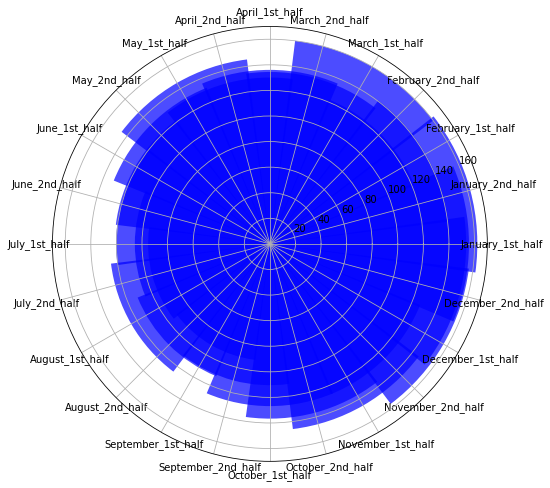

In [7]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['max'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 170)

plt.show()


# Statistical analysis

## 2022

In [113]:
#on enleve les dates ou time_traj>>

dates_2022=[date[4:8] for date in list(u_v_time_opt_2022.keys())]
dates_2022_best=[date[4:8] for date in list(data_best_2022.keys())]
dates_2022_worst=[date[4:8] for date in list(data_worst_2022.keys())]

In [114]:
avg_traj_time_2022,avg_traj_time_best_2022,avg_traj_time_worst_2022=get_avg_traj_time(traj_time_2022,traj_time_best_2022,traj_time_worst_2022)

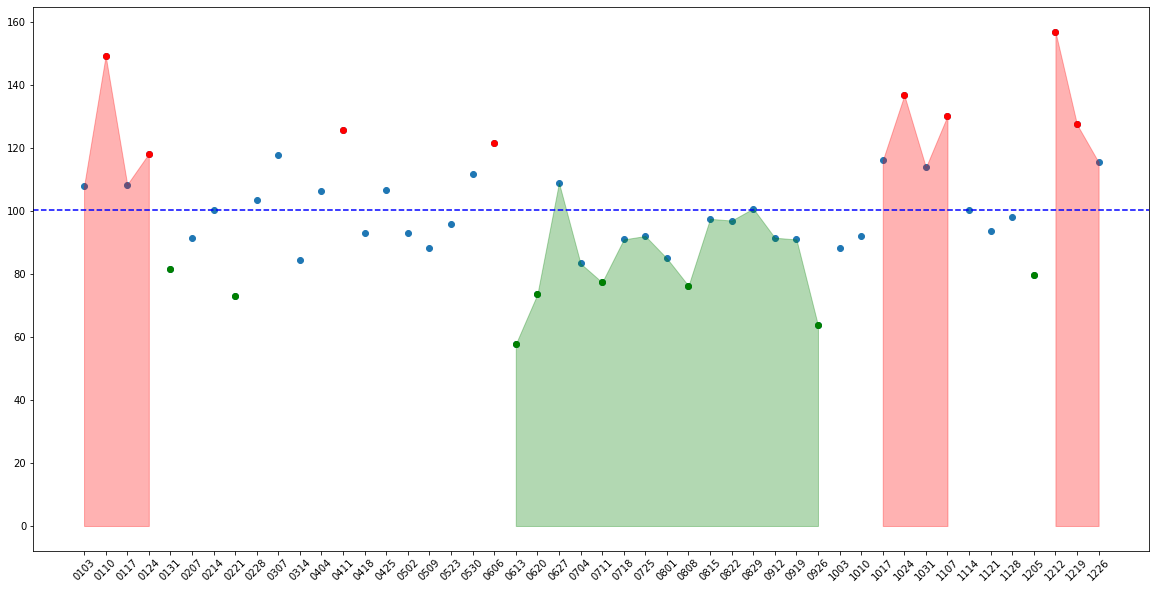

In [115]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2022, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2022,traj_time_2022)
plt.scatter(dates_2022_best,traj_time_best_2022,color='green')
plt.scatter(dates_2022_worst,traj_time_worst_2022,color='red')

#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0613'):dates_2022.index('0926')+1], traj_time_2022[dates_2022.index('0613'):dates_2022.index('0926')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('1017'):dates_2022.index('1107')+1], traj_time_2022[dates_2022.index('1017'):dates_2022.index('1107')+1],color='red', alpha=0.3)

#plt.axvline(x='1212', color='red', linestyle=':')
#plt.axvline(x='0124', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('1212'):dates_2022.index('1226')+1], traj_time_2022[dates_2022.index('1212'):dates_2022.index('1226')+1],color='red', alpha=0.3)
plt.fill_between(dates_2022[dates_2022.index('0103'):dates_2022.index('0124')+1], traj_time_2022[dates_2022.index('0103'):dates_2022.index('0124')+1],color='red', alpha=0.3)





Cond favorables en gén : 
- mi-juin à fin sept (contient les trajets les + courts et les traj en gén en dessous la moy)

Cond les moins fav : 

- mi oct à fin oct + mi décembre à fin janv 


outliers: 20220516 et 20220905 (trop short < 20) + 20220321 et 20220328 (trop long > 380)

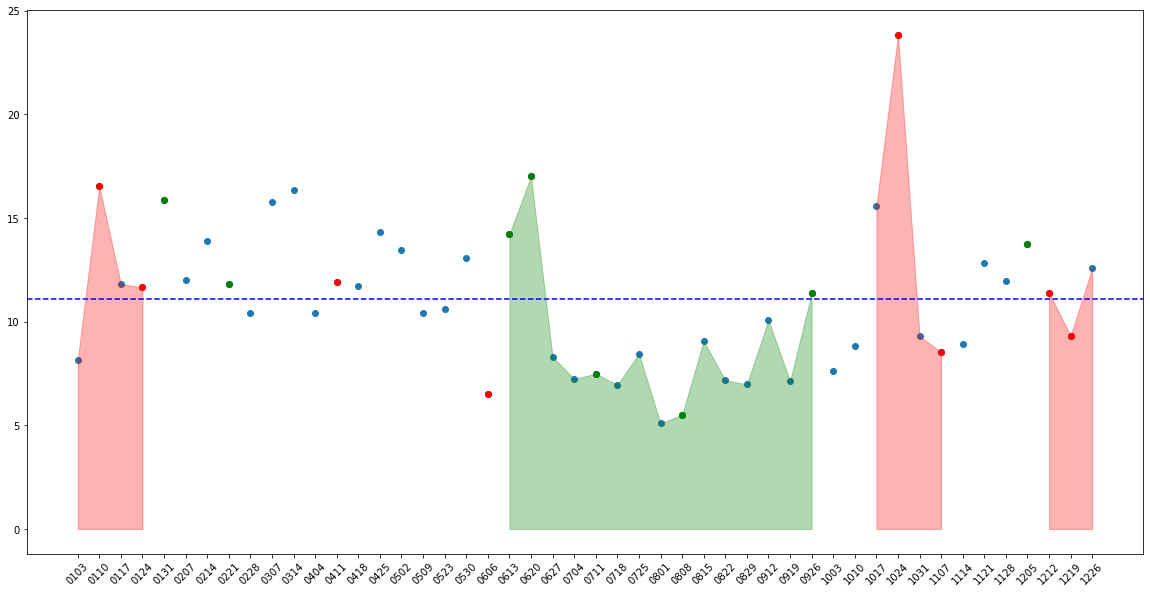

In [116]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2022, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2022,windspeed_2022)
plt.scatter(dates_2022_best,windspeed_best_2022,color='green')
plt.scatter(dates_2022_worst,windspeed_worst_2022,color='red')


#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0613'):dates_2022.index('0926')+1], windspeed_2022[dates_2022.index('0613'):dates_2022.index('0926')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('1017'):dates_2022.index('1107')+1], windspeed_2022[dates_2022.index('1017'):dates_2022.index('1107')+1],color='red', alpha=0.3)

#plt.axvline(x='1212', color='red', linestyle=':')
#plt.axvline(x='0124', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('1212'):dates_2022.index('1226')+1], windspeed_2022[dates_2022.index('1212'):dates_2022.index('1226')+1],color='red', alpha=0.3)
plt.fill_between(dates_2022[dates_2022.index('0103'):dates_2022.index('0124')+1], windspeed_2022[dates_2022.index('0103'):dates_2022.index('0124')+1],color='red', alpha=0.3)



Graphe donne certains infos mais pas complet !! 

En gén, meilleure période caractérisée par le vent en-dessous de la moyenne (vent de vit faible)

Qd le vent est très fort (>20 m/s, i.e. > 72 km/h), temps de trajet >>

Info limitée sur pires périodes car pas de winddir

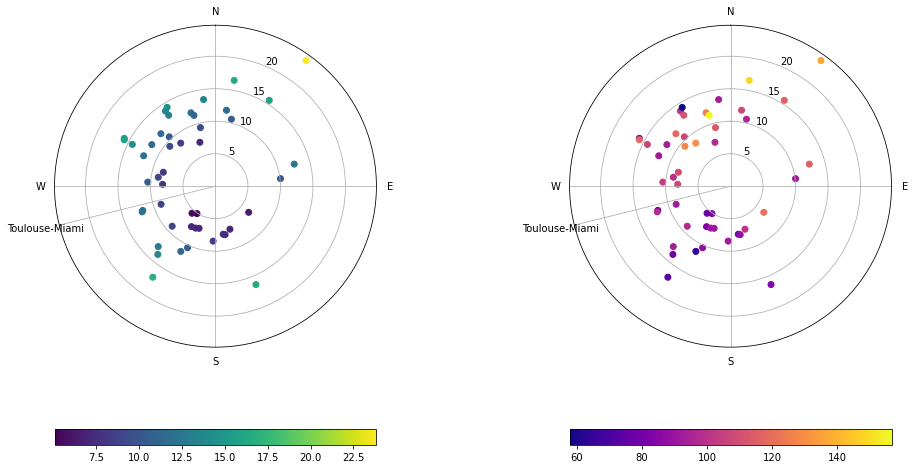

In [90]:
winddir_2022_rad=np.radians(winddir_2022)


#indices=np.arange(len(winddir_2022))
indices=windspeed_2022

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2022_rad, indices, c=windspeed_2022, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c1 = axes[1].scatter(winddir_2022_rad, indices, c=traj_time_2022, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal') #redondant

plt.subplots_adjust(wspace=0.6)
plt.show()

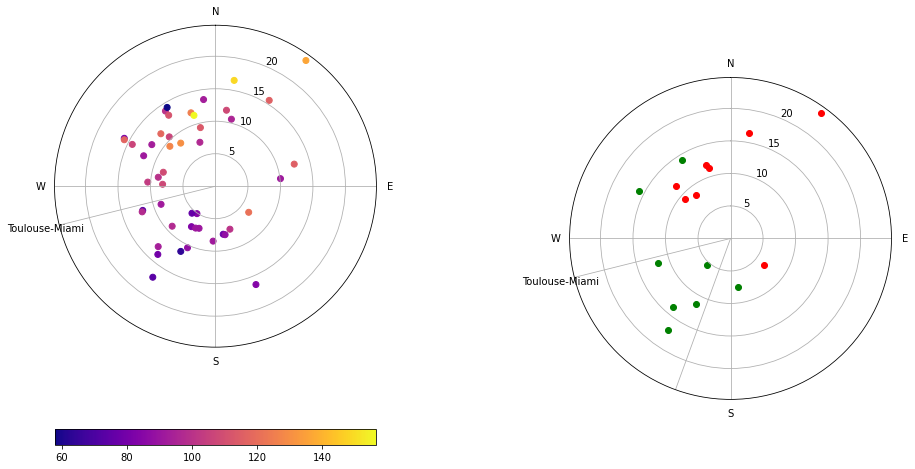

In [91]:
winddir_2022_rad=np.radians(winddir_2022)
winddir_best_2022_rad=np.radians(winddir_best_2022)
winddir_worst_2022_rad=np.radians(winddir_worst_2022)

#indices=np.arange(len(winddir_2022))
indices=windspeed_2022
indices_best=windspeed_best_2022
indices_worst=windspeed_worst_2022

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)


c0 = axes[0].scatter(winddir_2022_rad, indices, c=traj_time_2022, cmap='plasma')
axes[0].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c1=axes[1].scatter(winddir_best_2022_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c2=axes[1].scatter(winddir_worst_2022_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,200,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','','Toulouse-Miami', 'W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')

plt.subplots_adjust(wspace=0.6)
plt.show()

In [92]:
#get average wind conditions and travel time over 2022
avg_windspeed_2022,avg_winddir_2022,avg_windspeed_best_2022,avg_winddir_best_2022,avg_windspeed_worst_2022,avg_winddir_worst_2022=get_avg_wind_cond(windspeed_2022,winddir_2022,windspeed_best_2022,winddir_best_2022,windspeed_worst_2022,winddir_worst_2022)

print("Average wind speed 2022:",avg_windspeed_2022)
print("Average wind direction 2022:",avg_winddir_2022)
print("Average trajectory time 2022:",avg_traj_time_2022,'\n')

print("Average wind speed of 15% shortest traj_opt 2022:",avg_windspeed_best_2022)
print("Average wind direction of 15% shortest traj_opt 2022::",avg_winddir_best_2022)
print("Average trajectory time of 15% shortest traj_opt 2022:",avg_traj_time_best_2022,'\n')

print("Average wind speed of 15% longest traj_opt 2022:",avg_windspeed_worst_2022)
print("Average wind direction of 15% longest traj_opt 2022:",avg_winddir_worst_2022)
print("Average trajectory time of 15% longest traj_opt 2022:",avg_traj_time_worst_2022,'\n')


Average wind speed 2022: 11.107172592963133
Average wind direction 2022: 278.1289616363225
Average trajectory time 2022: 100.18404961148144 

Average wind speed of 15% shortest traj_opt 2022: 12.125331875417741
Average wind direction of 15% shortest traj_opt 2022:: 234.70952837102823
Average trajectory time of 15% shortest traj_opt 2022: 72.79103649902777 

Average wind speed of 15% longest traj_opt 2022: 12.458865185841878
Average wind direction of 15% longest traj_opt 2022: 347.4175955790745
Average trajectory time of 15% longest traj_opt 2022: 133.1327648865625 



In [96]:
the_best_data_2022, the_worst_data_2022=get_the_best_worst(u_v_time_opt_2022)

print("The shortest trajectory time data 2022:",the_best_data_2022)
print("The longest trajectory time data 2022:",the_worst_data_2022)

The shortest trajectory time data 2022: ('202206130000', [(array([17.21084595, 17.21084595, 17.21084595, 17.21084595, 14.58926392,
       16.30703735, 16.30703735, 19.01553345, 19.01553345, 17.64395142,
       17.64395142, 16.40859985, 16.40859985, 17.08096313, 17.08096313,
       17.78994751, 17.98672485, 17.98672485, 17.3944397 , 17.3944397 ,
       14.28994751, 14.28994751, 14.28994751, 14.28994751, 14.28994751,
       14.6913147 , 14.6913147 , 14.6913147 , 16.57803345, 16.57803345,
       18.52383423, 20.1991272 , 20.64492798, 20.4593811 , 20.4593811 ,
       18.99307251, 17.71133423, 18.35440063, 16.70986938, 18.32315063,
       18.61856079, 18.61856079, 18.28018188, 19.93496704, 22.0819397 ,
       12.27749634, 12.27749634,  8.32632446,  8.32632446,  7.76870728,
        9.13735962, 10.36245728, 10.33462524, 10.33462524, 11.49136353,
       12.04605103, 11.4503479 , 10.86245728, 10.19985962, 10.19985962,
        9.58804321,  8.74282837,  7.50650024,  6.44400024,  5.07144165,
     

## 2021

In [109]:
dates_2021=[date[4:8] for date in list(u_v_time_opt_2021.keys())]
dates_2021_best=[date[4:8] for date in list(data_best_2021.keys())]
dates_2021_worst=[date[4:8] for date in list(data_worst_2021.keys())]

In [110]:
avg_traj_time_2021,avg_traj_time_best_2021,avg_traj_time_worst_2021=get_avg_traj_time(traj_time_2021,traj_time_best_2021,traj_time_worst_2021)

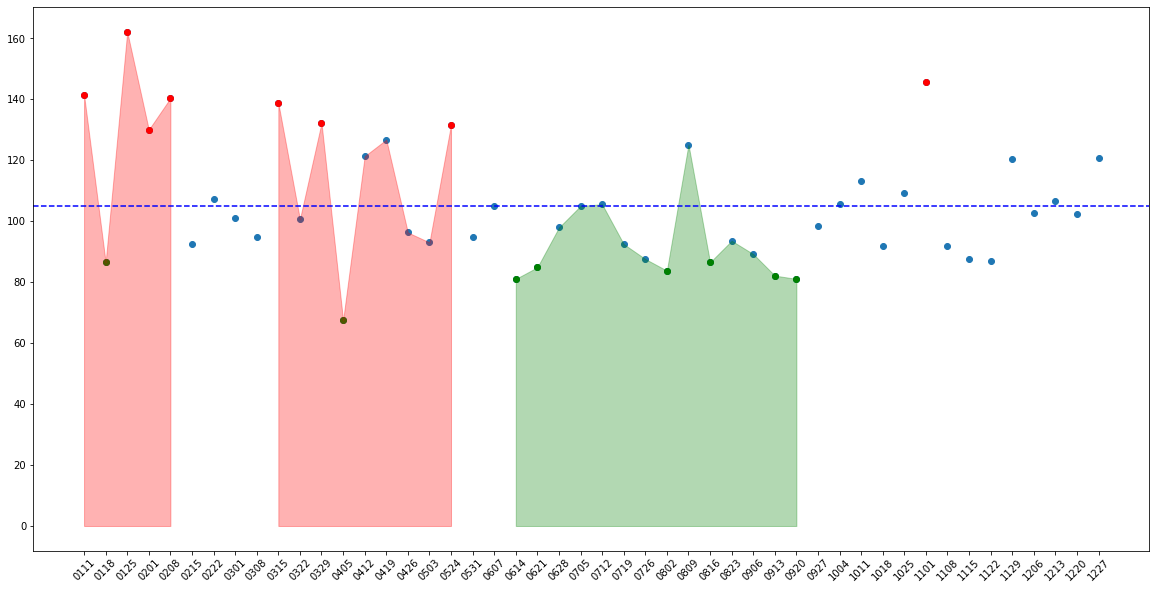

In [122]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2021, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2021,traj_time_2021)
plt.scatter(dates_2021_best,traj_time_best_2021,color='green')
plt.scatter(dates_2021_worst,traj_time_worst_2021,color='red')

#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2021[dates_2021.index('0614'):dates_2021.index('0920')+1], traj_time_2021[dates_2021.index('0614'):dates_2021.index('0920')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2021[dates_2021.index('0315'):dates_2021.index('0524')+1], traj_time_2021[dates_2021.index('0315'):dates_2021.index('0524')+1],color='red', alpha=0.3)

#plt.axvline(x='1212', color='red', linestyle=':')
#plt.axvline(x='0124', color='red', linestyle=':')
#plt.fill_between(dates_2021[dates_2021.index('1212'):dates_2021.index('1226')+1], traj_time_2021[dates_2021.index('1212'):dates_2021.index('1226')+1],color='red', alpha=0.3)
plt.fill_between(dates_2021[dates_2021.index('0111'):dates_2021.index('0208')+1], traj_time_2021[dates_2021.index('0111'):dates_2021.index('0208')+1],color='red', alpha=0.3)





jsp si on compte 0315-0524 comme mauvaise ??

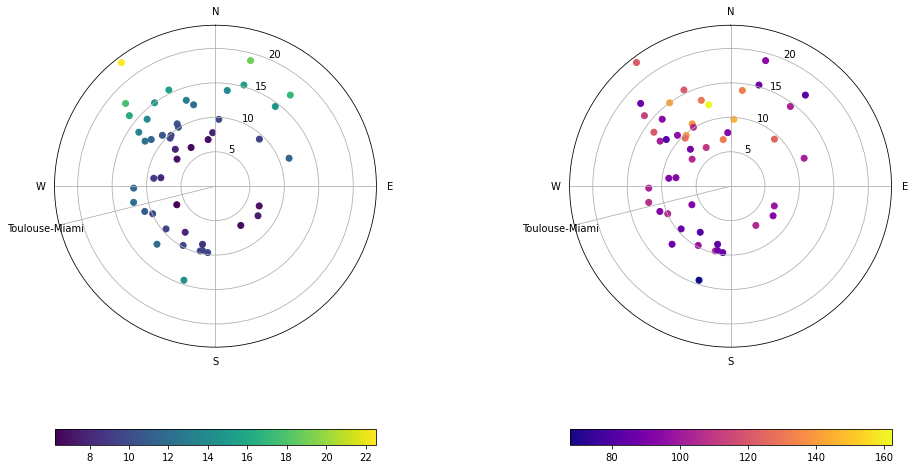

In [123]:
winddir_2021_rad=np.radians(winddir_2021)


#indices=np.arange(len(winddir_2022))
indices=windspeed_2021

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2021_rad, indices, c=windspeed_2021, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c1 = axes[1].scatter(winddir_2021_rad, indices, c=traj_time_2021, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal') #redondant

plt.subplots_adjust(wspace=0.6)
plt.show()

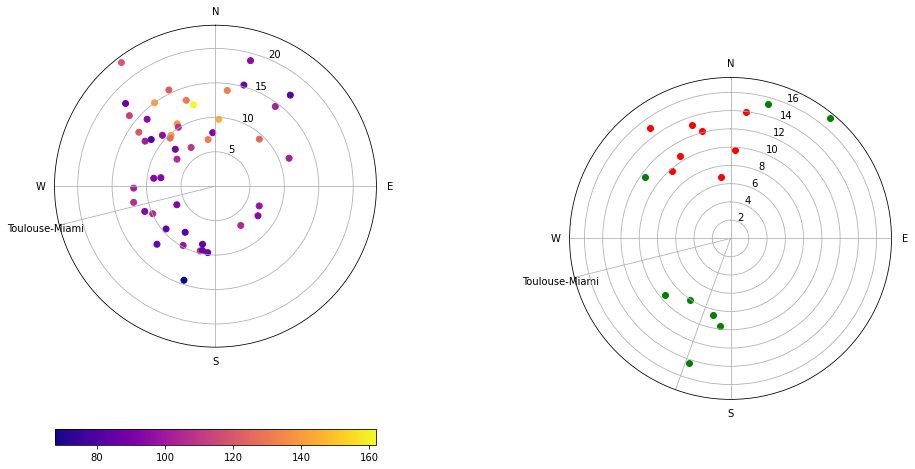

In [124]:
winddir_2021_rad=np.radians(winddir_2021)
winddir_best_2021_rad=np.radians(winddir_best_2021)
winddir_worst_2021_rad=np.radians(winddir_worst_2021)

#indices=np.arange(len(winddir_2022))
indices=windspeed_2021
indices_best=windspeed_best_2021
indices_worst=windspeed_worst_2021

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)


c0 = axes[0].scatter(winddir_2021_rad, indices, c=traj_time_2021, cmap='plasma')
axes[0].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c1=axes[1].scatter(winddir_best_2021_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','Toulouse-Miami', 'W'])

c2=axes[1].scatter(winddir_worst_2021_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,200,256, 270]))
axes[1].set_xticklabels(['N', 'E', 'S','','Toulouse-Miami', 'W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')

plt.subplots_adjust(wspace=0.6)
plt.show()

In [126]:
#get average wind conditions over 2021

avg_windspeed_2021,avg_winddir_2021,avg_windspeed_best_2021,avg_winddir_best_2021,avg_windspeed_worst_2021,avg_winddir_worst_2021=get_avg_wind_cond(windspeed_2021,winddir_2021,windspeed_best_2021,winddir_best_2021,windspeed_worst_2021,winddir_worst_2021)

print("Average wind speed 2021:",avg_windspeed_2021)
print("Average wind direction 2021:",avg_winddir_2021)
print("Average trajectory time 2021:",avg_traj_time_2021,'\n')

print("Average wind speed of 25% shortest traj_opt 2021:",avg_windspeed_best_2021)
print("Average wind direction of 25% shortest traj_opt 2021::",avg_winddir_best_2021)
print("Average trajectory time of 25% shortest traj_opt 2021:",avg_traj_time_best_2021,'\n')

print("Average wind speed of 25% longest traj_opt 2021:",avg_windspeed_worst_2021)
print("Average wind direction of 25% longest traj_opt 2021:",avg_winddir_worst_2021)
print("Average trajectory time of 25% longest traj_opt 2021:",avg_traj_time_worst_2021,'\n')


Average wind speed 2021: 11.274662452667036
Average wind direction 2021: 305.0995111186899
Average trajectory time 2021: 105.10481438412614 

Average wind speed of 25% shortest traj_opt 2021: 11.766277749772131
Average wind direction of 25% shortest traj_opt 2021:: 221.77231537292909
Average trajectory time of 25% shortest traj_opt 2021: 81.7028362946875 

Average wind speed of 25% longest traj_opt 2021: 11.424949237284546
Average wind direction of 25% longest traj_opt 2021: 342.26599384321685
Average trajectory time of 25% longest traj_opt 2021: 140.34383953038196 



## 2020

In [127]:
#on enleve les dates ou time_traj>>
dates_str_2020_new=list(np.copy(dates_str_2020))

dates_2020=[date[4:8] for date in dates_str_2020_new]
dates_2020_best=[date[4:8] for date in list(data_best_2020.keys())]
dates_2020_worst=[date[4:8] for date in list(data_worst_2020.keys())]

NameError: name 'avg_traj_time_2020' is not defined

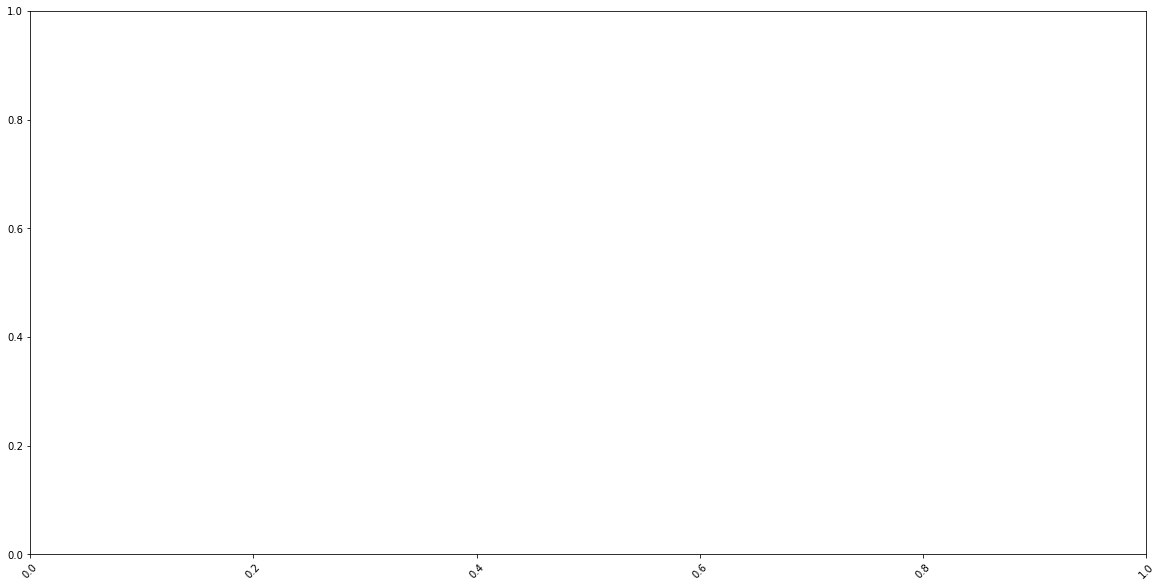

In [128]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2020, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2020,traj_time_2020)
plt.scatter(dates_2020_best,traj_time_2020_best,color='green')
plt.scatter(dates_2020_worst,traj_time_2020_worst,color='red')
#plt.scatter(['0321','0328'],[400,400],color='black')

Cond favorables en gén : mi-juin à fin sept (contient les trajets les + courts et les traj en gén en dessous la moy)
Cond les moins fav : mi oct à fin oct + mi décembre à fin janv 


In [ ]:
#recup vit moy a partir de fichier grib (sur tte l'annee)

In [ ]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2020, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2020,windspeed_2020)
plt.scatter(dates_2020_best,windspeed_best_2020,color='green')
plt.scatter(dates_2020_worst,windspeed_worst_2020,color='red')
#plt.scatter(['0321','0328'],[400,400],color='black')

In [ ]:
winddir_2020_rad=np.radians(winddir_2020)
#winddir_2022_best_rad=np.radians(winddir_best_2022)
#winddir_2022_worst_rad=np.radians(winddir_worst_2022)

indices=np.arange(len(winddir_2020))
#indices_best = np.where(np.isin(winddir_2022, winddir_best_2022))[0]
#indices_worst = np.where(np.isin(winddir_2022, winddir_worst_2022))[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2020_rad, indices, c=windspeed_2020, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180, 270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'W'])

c1 = axes[1].scatter(winddir_2020_rad, indices, c=traj_time_2020, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180, 270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'W'])

fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
#get average wind conditions over 2021

avg_windspeed_2020,avg_winddir_2020,avg_windspeed_best_2020,avg_winddir_best_2020,avg_windspeed_worst_2020,avg_winddir_worst_2020=get_avg_wind_cond(windspeed_2020,winddir_2020,windspeed_best_2020,winddir_best_2020,windspeed_worst_2020,winddir_worst_2020)
avg_traj_time_2020,avg_traj_time_2020_best,avg_traj_time_2020_worst=get_avg_traj_time(traj_time_2020,traj_time_2020_best,traj_time_2020_worst)

print("Average wind speed 2020:",avg_windspeed_2020)
print("Average wind direction 2020:",avg_winddir_2020)
print("Average trajectory time 2020:",avg_traj_time_2020,'\n')

print("Average wind speed of 25% shortest traj_opt 2020:",avg_windspeed_best_2020)
print("Average wind direction of 25% shortest traj_opt 2020::",avg_winddir_best_2020)
print("Average trajectory time of 25% shortest traj_opt 2020:",avg_traj_time_2020_best,'\n')

print("Average wind speed of 25% longest traj_opt 2020:",avg_windspeed_worst_2020)
print("Average wind direction of 25% longest traj_opt 2020:",avg_winddir_worst_2020)
print("Average trajectory time of 25% longest traj_opt 2020:",avg_traj_time_2020_worst,'\n')
